# Исследование причин неэффективности привлечения пользователей приложения.

Развлекательное приложение Procrastinate Pro+ несет убытки в течение нескольких прошлых месяцев. Деньги, вложенные в привлечение пользователей не увеличивают прибыльность.

В нашем распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. Нужно изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отрицательно влияют на привлечение пользователей.

Необходимо найти возможные причины обнаруженных проблем и сформировать рекомендации для отдела маркетинга для повышения эффективности.

## Загрузка данных и подготовка к анализу

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import datetime, timedelta
from scipy import stats as st

%config InlineBackend.figure_format = 'retina'

In [5]:
visits = pd.read_csv('/content/drive/MyDrive/unit_project/visits_info_short.csv')
visits

User Id         Region   Device         Channel  \
0       981449118918  United States   iPhone         organic   
1       278965908054  United States   iPhone         organic   
2       590706206550  United States      Mac         organic   
3       326433527971  United States  Android          TipTop   
4       349773784594  United States      Mac         organic   
...              ...            ...      ...             ...   
309896  329994900775             UK       PC         LeapBob   
309897  334903592310         France       PC  lambdaMediaAds   
309898  540102010126        Germany       PC         organic   
309899  308736936846        Germany      Mac         organic   
309900  109329042535        Germany       PC  lambdaMediaAds   

              Session Start          Session End  
0       2019-05-01 02:36:01  2019-05-01 02:45:01  
1       2019-05-01 04:46:31  2019-05-01 04:47:35  
2       2019-05-01 14:09:25  2019-05-01 15:32:08  
3       2019-05-01 00:29:59  2019-05-01 00:54:25  
4       2019-05-01 03:33:35  2019-05-01 03:57:40  
...                     ...                  ...  
309896  2019-10-31 13:28:12  2019-10-31 14:39:29  
309897  2019-10-31 22:14:52  2019-10-31 22:39:36  
309898  2019-10-31 01:40:48  2019-10-31 01:41:31  
309899  2019-10-31 07:37:34  2019-10-31 07:37:55  
309900  2019-10-31 14:17:43  2019-10-31 15:17:04  

[309901 rows x 6 columns]

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [8]:
visits.columns = [x.lower().replace(' ', '_') for x in visits.columns]
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

In [9]:
visits[visits.duplicated()]

Empty DataFrame
Columns: [user_id, region, device, channel, session_start, session_end]
Index: []

In [10]:
visits[visits.duplicated(subset=['user_id', 'session_end'])]

Empty DataFrame
Columns: [user_id, region, device, channel, session_start, session_end]
Index: []

In [11]:
orders = pd.read_csv('/content/drive/MyDrive/unit_project/orders_info_short.csv')
orders

User Id             Event Dt  Revenue
0      188246423999  2019-05-01 23:09:52     4.99
1      174361394180  2019-05-01 12:24:04     4.99
2      529610067795  2019-05-01 11:34:04     4.99
3      319939546352  2019-05-01 15:34:40     4.99
4      366000285810  2019-05-01 13:59:51     4.99
...             ...                  ...      ...
40207  651604369137  2019-10-31 16:19:07     4.99
40208  275341387049  2019-10-31 01:17:17     4.99
40209  374656616484  2019-10-31 06:17:29     4.99
40210  168548862926  2019-10-31 22:46:19     4.99
40211  329994900775  2019-10-31 13:29:06     4.99

[40212 rows x 3 columns]

In [12]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [13]:
orders.columns = [x.lower().replace(' ', '_') for x in orders.columns]
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [14]:
orders[orders.duplicated()]

Empty DataFrame
Columns: [user_id, event_dt, revenue]
Index: []

In [15]:
orders[orders.duplicated(subset=['user_id', 'event_dt'])]

Empty DataFrame
Columns: [user_id, event_dt, revenue]
Index: []

In [16]:
costs = pd.read_csv('/content/drive/MyDrive/unit_project/costs_info_short.csv')
costs

dt         Channel  costs
0     2019-05-01        FaceBoom  113.3
1     2019-05-02        FaceBoom   78.1
2     2019-05-03        FaceBoom   85.8
3     2019-05-04        FaceBoom  136.4
4     2019-05-05        FaceBoom  122.1
...          ...             ...    ...
1795  2019-10-23  lambdaMediaAds    4.0
1796  2019-10-24  lambdaMediaAds    6.4
1797  2019-10-25  lambdaMediaAds    8.8
1798  2019-10-26  lambdaMediaAds    8.8
1799  2019-10-27  lambdaMediaAds   12.0

[1800 rows x 3 columns]

In [17]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [18]:
costs.columns = [x.lower() for x in costs.columns]
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

In [19]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [20]:
costs[costs.duplicated()]

Empty DataFrame
Columns: [dt, channel, costs]
Index: []

Загрузили таблицы для работы, изменили тип данных в датах для удобства работы, привели к нижнему регистру названия колонок. Проверили наличие дубликатов.

## Функции для расчета и анализа LTV, ROI, удержания и конверсии

### Функция для создания пользовательских профилей

In [21]:
# функция для создания пользовательских профилей

def get_profiles(visits, orders, costs):

    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
    costs = costs.merge(new_users, on=['dt', 'channel'], how='left')
    costs['acquisition_cost'] = costs['costs'] / costs['unique_users']
    profiles = profiles.merge(
        costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    return profiles

### Функция для расчёта удержания

In [22]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    dimensions = ['payer'] + dimensions
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return result_raw, result_grouped, result_in_time 

### Функция для расчёта конверсии

In [23]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)       
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    if 'cohort' in dimensions: 
        dimensions = []
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )
    return result_raw, result_grouped, result_in_time 

### Функция для расчёта LTV и ROI

In [24]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')  
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']
    def group_by_dimensions(df, dims, horizon_days):        
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )     
        result = result.fillna(0).cumsum(axis=1)      
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )      
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)       
        result = result.div(result['cohort_size'], axis=0)        
        result = result[['cohort_size'] + list(range(horizon_days))]       
        result['cohort_size'] = cohort_sizes
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )
        roi = result.div(cac['cac'], axis=0)
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        roi['cohort_size'] = cohort_sizes
        roi['cac'] = cac['cac']
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]
        return result, roi

    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )
    if 'cohort' in dimensions:
        dimensions = []
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  
        result_grouped,  
        result_in_time, 
        roi_grouped, 
        roi_in_time, 
    )

### Функция для сглаживания фрейма

In [25]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

### Функция для визуализации удержания

In [26]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    plt.figure(figsize=(15, 10))

    retention = retention.drop(columns=['cohort_size', 0])  
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    ax3 = plt.subplot(2, 2, 3)
    
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
   
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )   
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

### Функция для визуализации конверсии

In [27]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):
    plt.figure(figsize=(15, 5))
    conversion = conversion.drop(columns=['cohort_size'])
  
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
       
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

### Функция для визуализации LTV и ROI

In [28]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    plt.figure(figsize=(20, 10))

    ltv = ltv.drop(columns=['cohort_size'])
    
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]
    cac_history = roi_history[['cac']]
    roi = roi.drop(columns=['cohort_size', 'cac'])   
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
  
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

  
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')
   
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

   
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
   
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

## Исследовательский анализ данных

Построим профили пользователей, определим минимальную и максимальную дату привлечения пользователей.
Выясним:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

In [29]:
profiles = get_profiles(visits, orders, costs)
profiles.head()

user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True          1.088172  
1  2019-07-09 2019-07-01  False          1.107237  
2  2019-10-01 2019-10-01  False          0.000000  
3  2019-08-22 2019-08-01  False          0.988235  
4  2019-10-02 2019-10-01  False          0.230769

In [30]:
profiles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150008 entries, 0 to 150007
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_id           150008 non-null  int64         
 1   first_ts          150008 non-null  datetime64[ns]
 2   channel           150008 non-null  object        
 3   device            150008 non-null  object        
 4   region            150008 non-null  object        
 5   dt                150008 non-null  object        
 6   month             150008 non-null  datetime64[ns]
 7   payer             150008 non-null  bool          
 8   acquisition_cost  150008 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(1), int64(1), object(4)
memory usage: 10.4+ MB


In [31]:
profiles['first_ts'].min()

Timestamp('2019-05-01 00:00:41')

In [32]:
profiles['first_ts'].max()

Timestamp('2019-10-27 23:59:04')

In [33]:
observation_date = datetime(2019,11,1)
horizon_days = 14
last_suitable_acquisition_date = observation_date - timedelta(days = horizon_days-1)
pd.to_datetime(last_suitable_acquisition_date)

Timestamp('2019-10-19 00:00:00')

Самая ранняя дата регистрации 01 мая 2019. В нашем датафрейме самая поздняя дата регистрации - это 27 октября 2019 года, но даты позже 19 октября мы не будем брать в рассмотрение, т.к. наш анализ горизонта 14 дней, а сегодня 01 ноября 2019 года. 

### Анализ данных по региональному признаку

In [34]:
profiles.query('payer == True')['user_id'].count()

8881

In [35]:
profiles['region'].value_counts()

United States    100002
UK                17575
France            17450
Germany           14981
Name: region, dtype: int64

In [36]:
profiles.query('payer == True')['region'].value_counts()

United States    6902
UK                700
France            663
Germany           616
Name: region, dtype: int64

In [37]:
profiles.query('payer == False')['region'].value_counts()

United States    93100
UK               16875
France           16787
Germany          14365
Name: region, dtype: int64

In [38]:
reg_tbl = profiles.groupby('region').agg({'user_id':'nunique','payer':['sum','mean']})
reg_tbl.columns = ['users', 'payers', 'payers,%']
reg_tbl['payers,%'] = round(reg_tbl['payers,%']*100,2)
reg_tbl.sort_values(by='users',ascending=False)

users  payers  payers,%
region                                 
United States  100002    6902      6.90
UK              17575     700      3.98
France          17450     663      3.80
Germany         14981     616      4.11

In [39]:
profiles['region'].value_counts()/profiles['user_id'].count()*100

United States    66.664445
UK               11.716042
France           11.632713
Germany           9.986801
Name: region, dtype: float64

In [40]:
profiles.query('payer == True')['region'].value_counts()/profiles.query('payer == True')['user_id'].count()*100

United States    77.716473
UK                7.881995
France            7.465376
Germany           6.936156
Name: region, dtype: float64

Америка - абсолютный лидер по количеству пользователей (66,7%) и по платящим пользователям (77,7%). Оттуда у нас 100 тыс.пользователей, из которых 6,9% совершают покупки. Великобритания, Франция и Германия дают гораздо меньше пользователей, покупателями становятся примерно 4% пользователей, в Германии этот показатель выше, чем у остальных.

### Анализ устройств, используемых пользователей

In [41]:
profiles['device'].value_counts()

iPhone     54479
Android    35032
PC         30455
Mac        30042
Name: device, dtype: int64

In [42]:
profiles.query('payer == True')['device'].value_counts()

iPhone     3382
Android    2050
Mac        1912
PC         1537
Name: device, dtype: int64

In [43]:
profiles.query('payer == False')['device'].value_counts()

iPhone     51097
Android    32982
PC         28918
Mac        28130
Name: device, dtype: int64

In [44]:
dev_tbl = profiles.groupby('device').agg({'user_id':'nunique','payer':['sum','mean']})
dev_tbl.columns = ['users', 'payers', 'payers,%']
dev_tbl['payers,%'] = round(dev_tbl['payers,%']*100,2)
dev_tbl.sort_values(by='users',ascending=False)

users  payers  payers,%
device                          
iPhone   54479    3382      6.21
Android  35032    2050      5.85
PC       30455    1537      5.05
Mac      30042    1912      6.36

In [45]:
profiles['device'].value_counts()/profiles['device'].count()*100

iPhone     36.317396
Android    23.353421
PC         20.302251
Mac        20.026932
Name: device, dtype: float64

In [46]:
profiles.query('payer == True')['device'].value_counts()/profiles.query('payer == True')['user_id'].count()*100

iPhone     38.081297
Android    23.082986
Mac        21.529107
PC         17.306610
Name: device, dtype: float64

### Анализ источников траффика

Больше всего пользователей заходят в приложение с iPhone (36,3%), они же наибольшая численная и относительная часть плательщиков (38,1%). В процентном соотношении мы видим, что пользователи Mac чаще остальных становятся покупателями (6,36%) и приносят 21,5% покупок. 

In [47]:
profiles['channel'].value_counts()

organic               56439
FaceBoom              29144
TipTop                19561
OppleCreativeMedia     8605
LeapBob                8553
WahooNetBanner         8553
RocketSuperAds         4448
MediaTornado           4364
YRabbit                4312
AdNonSense             3880
lambdaMediaAds         2149
Name: channel, dtype: int64

In [48]:
profiles.query('payer == True')['channel'].value_counts()

FaceBoom              3557
TipTop                1878
organic               1160
WahooNetBanner         453
AdNonSense             440
RocketSuperAds         352
LeapBob                262
OppleCreativeMedia     233
lambdaMediaAds         225
YRabbit                165
MediaTornado           156
Name: channel, dtype: int64

In [49]:
profiles.query('payer == False')['channel'].value_counts()

organic               55279
FaceBoom              25587
TipTop                17683
OppleCreativeMedia     8372
LeapBob                8291
WahooNetBanner         8100
MediaTornado           4208
YRabbit                4147
RocketSuperAds         4096
AdNonSense             3440
lambdaMediaAds         1924
Name: channel, dtype: int64

In [50]:
chan_tbl = profiles.groupby('channel').agg({'user_id':'nunique','payer':['sum','mean']})
chan_tbl.columns = ['users', 'payers', 'payers,%']
chan_tbl['payers,%'] = round(chan_tbl['payers,%']*100,2)
chan_tbl.sort_values(by='users',ascending=False)

users  payers  payers,%
channel                                    
organic             56439    1160      2.06
FaceBoom            29144    3557     12.20
TipTop              19561    1878      9.60
OppleCreativeMedia   8605     233      2.71
LeapBob              8553     262      3.06
WahooNetBanner       8553     453      5.30
RocketSuperAds       4448     352      7.91
MediaTornado         4364     156      3.57
YRabbit              4312     165      3.83
AdNonSense           3880     440     11.34
lambdaMediaAds       2149     225     10.47

In [51]:
profiles['channel'].value_counts()/profiles['channel'].count()*100

organic               37.623993
FaceBoom              19.428297
TipTop                13.039971
OppleCreativeMedia     5.736361
LeapBob                5.701696
WahooNetBanner         5.701696
RocketSuperAds         2.965175
MediaTornado           2.909178
YRabbit                2.874513
AdNonSense             2.586529
lambdaMediaAds         1.432590
Name: channel, dtype: float64

In [52]:
profiles.query('payer == True')['channel'].value_counts()/profiles.query('payer == True')['user_id'].count()*100

FaceBoom              40.051796
TipTop                21.146267
organic               13.061592
WahooNetBanner         5.100777
AdNonSense             4.954397
RocketSuperAds         3.963518
LeapBob                2.950118
OppleCreativeMedia     2.623578
lambdaMediaAds         2.533498
YRabbit                1.857899
MediaTornado           1.756559
Name: channel, dtype: float64

Больше всего пользователей (37%) приводит к нам естественный траффик, они очень редко (2,06% случаев) становятся плательщиками, но занимают третье место среди всех платящих пользователей (13%). Мы анализируем именно привлечение пользователей, на которое были потрачены деньги. На привлечение пользователей из источника "organic" не тратили ничего, пользователи приходили сами.

Среди источников, на коткорые были выделены рекламные средства, у платящих на первом месте Faceboom (40%), затем TipTop (21%), остальные приносят меньше 5% покупателей.

## Маркетинг

Выясним:
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

In [53]:
observation_date = datetime(2019,11,1).date()
horizon_days = 14
costs['month'] = costs['dt'].astype('datetime64[M]')

In [54]:
costs

dt         channel  costs      month
0     2019-05-01        FaceBoom  113.3 2019-05-01
1     2019-05-02        FaceBoom   78.1 2019-05-01
2     2019-05-03        FaceBoom   85.8 2019-05-01
3     2019-05-04        FaceBoom  136.4 2019-05-01
4     2019-05-05        FaceBoom  122.1 2019-05-01
...          ...             ...    ...        ...
1795  2019-10-23  lambdaMediaAds    4.0 2019-10-01
1796  2019-10-24  lambdaMediaAds    6.4 2019-10-01
1797  2019-10-25  lambdaMediaAds    8.8 2019-10-01
1798  2019-10-26  lambdaMediaAds    8.8 2019-10-01
1799  2019-10-27  lambdaMediaAds   12.0 2019-10-01

[1800 rows x 4 columns]

In [55]:
costs['costs'].sum()

105497.30000000002

In [56]:
costs.groupby('channel')['costs'].sum().sort_values(ascending=False)

channel
TipTop                54751.30
FaceBoom              32445.60
WahooNetBanner         5151.00
AdNonSense             3911.25
OppleCreativeMedia     2151.25
RocketSuperAds         1833.00
LeapBob                1797.60
lambdaMediaAds         1557.60
MediaTornado            954.48
YRabbit                 944.22
Name: costs, dtype: float64

In [57]:
costs.groupby('month')['costs'].sum()

month
2019-05-01     9978.570
2019-06-01    15090.045
2019-07-01    16447.060
2019-08-01    20657.870
2019-09-01    22441.340
2019-10-01    20882.415
Name: costs, dtype: float64

<Axes: xlabel='dt'>

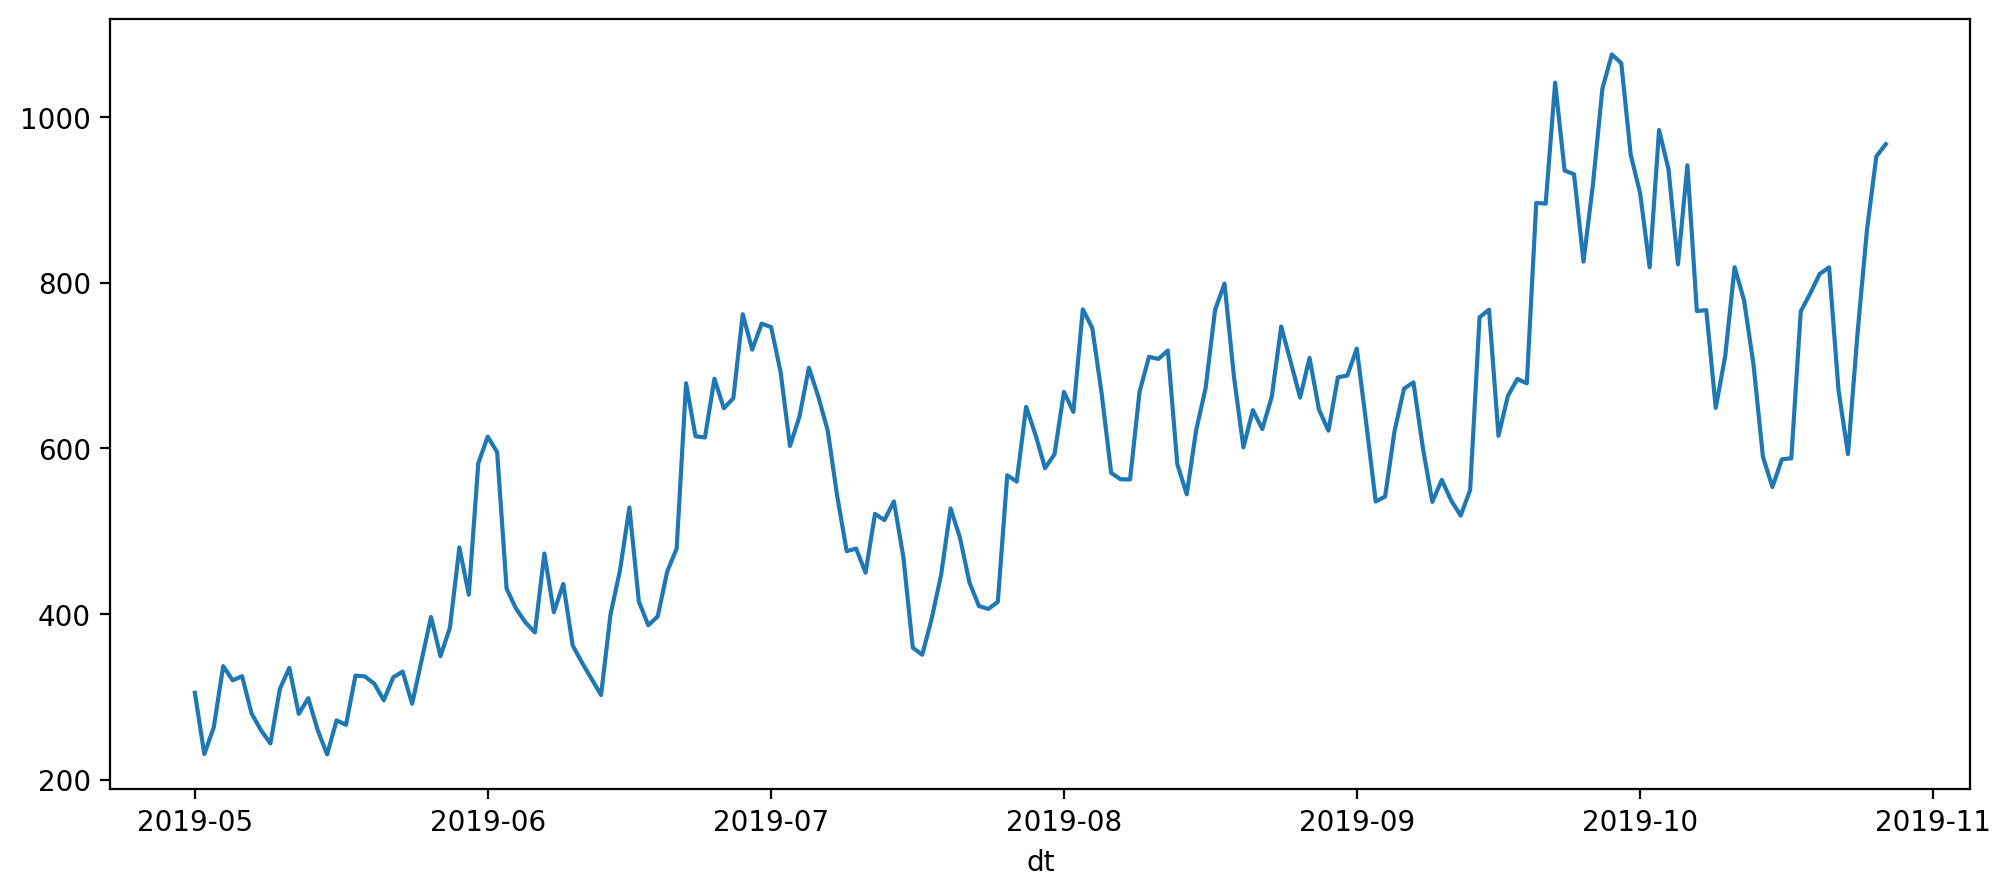

In [58]:
costs.groupby('dt')['costs'].sum().plot(figsize=(12,5))

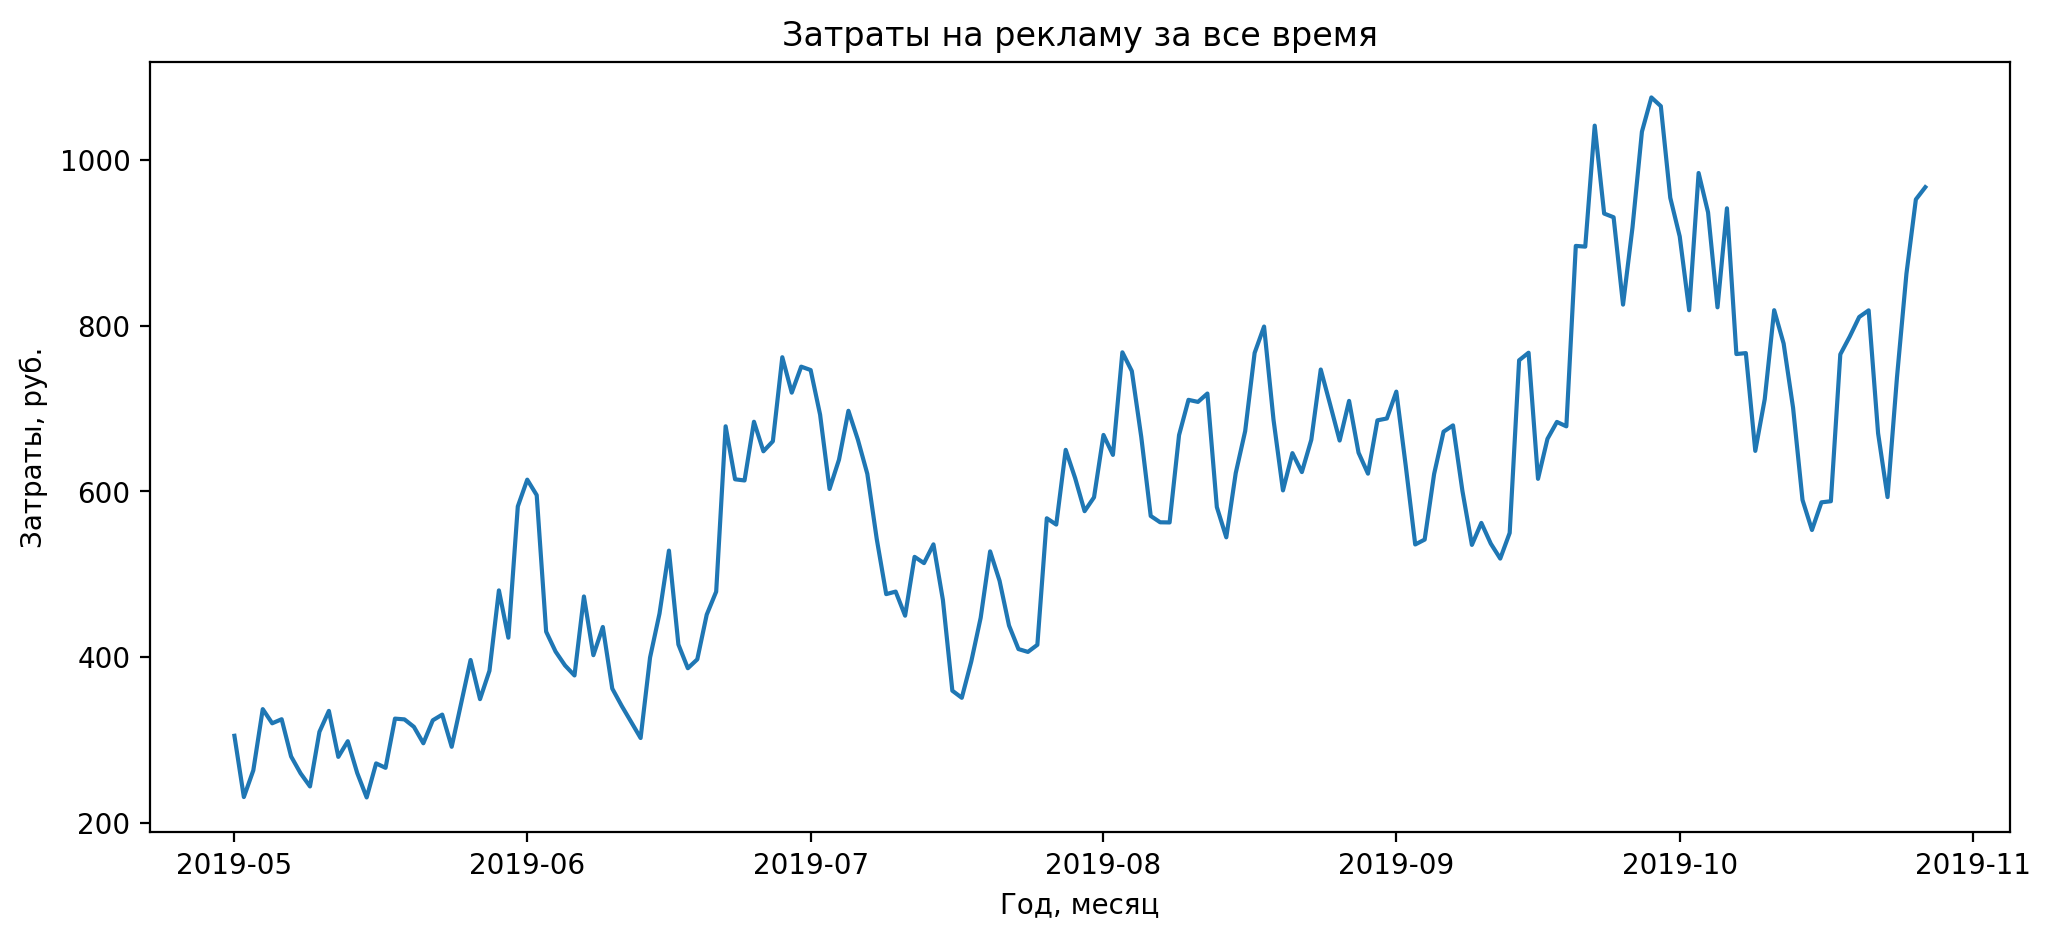

In [59]:
plt.figure()
costs.groupby('dt')['costs'].sum().plot(title='Затраты на рекламу за все время', ax=plt.subplot(), figsize=(12,5))
plt.xlabel('Год, месяц')
plt.ylabel('Затраты, руб.')
plt.show()

<div class="alert alert-danger">
<b>Комментарий ревьюера:</b>☁️

Давай доработаем графики, добавь, пожалуйста, заголовок и подписи осей. ЧТобы избавиться от `<AxesSubplot:xlabel='dt'>
`, можно поставить `;` в конце строки или же написать `plt.show()`
</div>


<div class="alert alert-info"> Добавила исправленный график под неправильным </div>

<div class="alert alert-success">
<b>Комментарий ревьюера v2:</b>☀️
    
Отлично и ниже по работе тоже графики изменены
</div>


In [60]:
profiles.groupby('month')['user_id'].count()

month
2019-05-01    27111
2019-06-01    23123
2019-07-01    22627
2019-08-01    26586
2019-09-01    26327
2019-10-01    24234
Name: user_id, dtype: int64

In [61]:
profiles.groupby('month')['user_id'].count().mean()

25001.333333333332

Всего на рекламу было потрачено 105497 руб. Больше половины этой суммы (54751 руб.) ушло в TipTop, в FaceBoom заплатили 32445 руб., на остальные источники потрачены было 5 и менее тыс. руб. 

Количество новых пользователей в среднем 25 тыс. чел., наибольший приток был в мае, когда затраты на рекламу были самыми низкими. Рекламный бюджет от месяца к месяцу рос до сентября, затем в октябре немного снижен.

Добавим в таблицу данные о выручке с пользователей и продолжим анализ.

In [62]:
user_price = profiles.groupby('channel').agg({'user_id':'nunique','payer':'sum','acquisition_cost':'sum'})
user_price['cost_per_user'] = user_price['acquisition_cost']/user_price['user_id']
user_price['cost_per_payer'] = user_price['acquisition_cost']/user_price['payer']
user_price.sort_values(by='acquisition_cost', ascending=False)

user_id  payer  acquisition_cost  cost_per_user  \
channel                                                               
TipTop                19561   1878          54751.30       2.799003   
FaceBoom              29144   3557          32445.60       1.113286   
WahooNetBanner         8553    453           5151.00       0.602245   
AdNonSense             3880    440           3911.25       1.008054   
OppleCreativeMedia     8605    233           2151.25       0.250000   
RocketSuperAds         4448    352           1833.00       0.412095   
LeapBob                8553    262           1797.60       0.210172   
lambdaMediaAds         2149    225           1557.60       0.724802   
MediaTornado           4364    156            954.48       0.218717   
YRabbit                4312    165            944.22       0.218975   
organic               56439   1160              0.00       0.000000   

                    cost_per_payer  
channel                             
TipTop                   29.154047  
FaceBoom                  9.121619  
WahooNetBanner           11.370861  
AdNonSense                8.889205  
OppleCreativeMedia        9.232833  
RocketSuperAds            5.207386  
LeapBob                   6.861069  
lambdaMediaAds            6.922667  
MediaTornado              6.118462  
YRabbit                   5.722545  
organic                   0.000000

In [63]:
orders_sum = orders.groupby('user_id')['revenue'].sum()
profiles_with_orders = profiles.merge(orders_sum, on='user_id', how='left')
profiles_with_orders = profiles_with_orders.fillna(0)
profiles_with_orders

user_id            first_ts       channel  device         region  \
0             599326 2019-05-07 20:58:57      FaceBoom     Mac  United States   
1            4919697 2019-07-09 12:46:07      FaceBoom  iPhone  United States   
2            6085896 2019-10-01 09:58:33       organic  iPhone         France   
3           22593348 2019-08-22 21:35:48    AdNonSense      PC        Germany   
4           31989216 2019-10-02 00:07:44       YRabbit  iPhone  United States   
...              ...                 ...           ...     ...            ...   
150003  999956196527 2019-09-28 08:33:02        TipTop  iPhone  United States   
150004  999975439887 2019-10-21 00:35:17       organic      PC             UK   
150005  999976332130 2019-07-23 02:57:06        TipTop  iPhone  United States   
150006  999979924135 2019-09-28 21:28:09  MediaTornado      PC  United States   
150007  999999563947 2019-10-18 19:57:25       organic  iPhone  United States   

                dt      month  payer  acquisition_cost  revenue  
0       2019-05-07 2019-05-01   True          1.088172    14.97  
1       2019-07-09 2019-07-01  False          1.107237     0.00  
2       2019-10-01 2019-10-01  False          0.000000     0.00  
3       2019-08-22 2019-08-01  False          0.988235     0.00  
4       2019-10-02 2019-10-01  False          0.230769     0.00  
...            ...        ...    ...               ...      ...  
150003  2019-09-28 2019-09-01  False          3.500000     0.00  
150004  2019-10-21 2019-10-01  False          0.000000     0.00  
150005  2019-07-23 2019-07-01  False          2.600000     0.00  
150006  2019-09-28 2019-09-01  False          0.205714     0.00  
150007  2019-10-18 2019-10-01  False          0.000000     0.00  

[150008 rows x 10 columns]

Проверим, правильно ли сосчитана выручка.

In [64]:
profiles_with_orders['revenue'].sum()

215962.87999999998

In [65]:
orders['revenue'].sum()

215962.88

In [66]:
user_revenue = profiles_with_orders.groupby('channel').agg({'user_id':'nunique','payer':'sum','acquisition_cost':'sum','revenue':'sum'})
user_revenue['cost_per_user'] = user_revenue['acquisition_cost']/user_revenue['user_id']
user_revenue['cost_per_payer'] = user_revenue['acquisition_cost']/user_revenue['payer']
user_revenue['revenue_per_payer'] = user_revenue['revenue']/user_revenue['payer']
user_revenue.sort_values(by='revenue_per_payer', ascending=False)

user_id  payer  acquisition_cost   revenue  cost_per_user  \
channel                                                                         
WahooNetBanner         8553    453           5151.00  20006.63       0.602245   
organic               56439   1160              0.00  46627.23       0.000000   
lambdaMediaAds         2149    225           1557.60   8941.70       0.724802   
YRabbit                4312    165            944.22   6201.43       0.218975   
TipTop                19561   1878          54751.30  69574.76       2.799003   
MediaTornado           4364    156            954.48   5752.32       0.218717   
LeapBob                8553    262           1797.60   9560.13       0.210172   
OppleCreativeMedia     8605    233           2151.25   8365.53       0.250000   
RocketSuperAds         4448    352           1833.00  11598.32       0.412095   
AdNonSense             3880    440           3911.25   3697.17       1.008054   
FaceBoom              29144   3557          32445.60  25637.66       1.113286   

                    cost_per_payer  revenue_per_payer  
channel                                                
WahooNetBanner           11.370861          44.164746  
organic                   0.000000          40.195888  
lambdaMediaAds            6.922667          39.740889  
YRabbit                   5.722545          37.584424  
TipTop                   29.154047          37.047263  
MediaTornado              6.118462          36.873846  
LeapBob                   6.861069          36.489046  
OppleCreativeMedia        9.232833          35.903562  
RocketSuperAds            5.207386          32.949773  
AdNonSense                8.889205           8.402659  
FaceBoom                  9.121619           7.207664

Если посмотреть на показатель выручки на одного платящего пользователя, то  TipTop и FaceBoom, на которые ушла львиная часть рекламного бюджета точно не самые результативные.  А FaceBoom вообще на последней строчке, стоимость привлечения одного платящего пользователя здесь составила 9.12, а выручка с платящего пользователя 7.2, мы видим явный убыток. 

"Качество" платящих пользователей рассмотрим на гистограммах для трех самых прибыльных источниках траффика и для сравнения FaceBoom.

<Axes: >

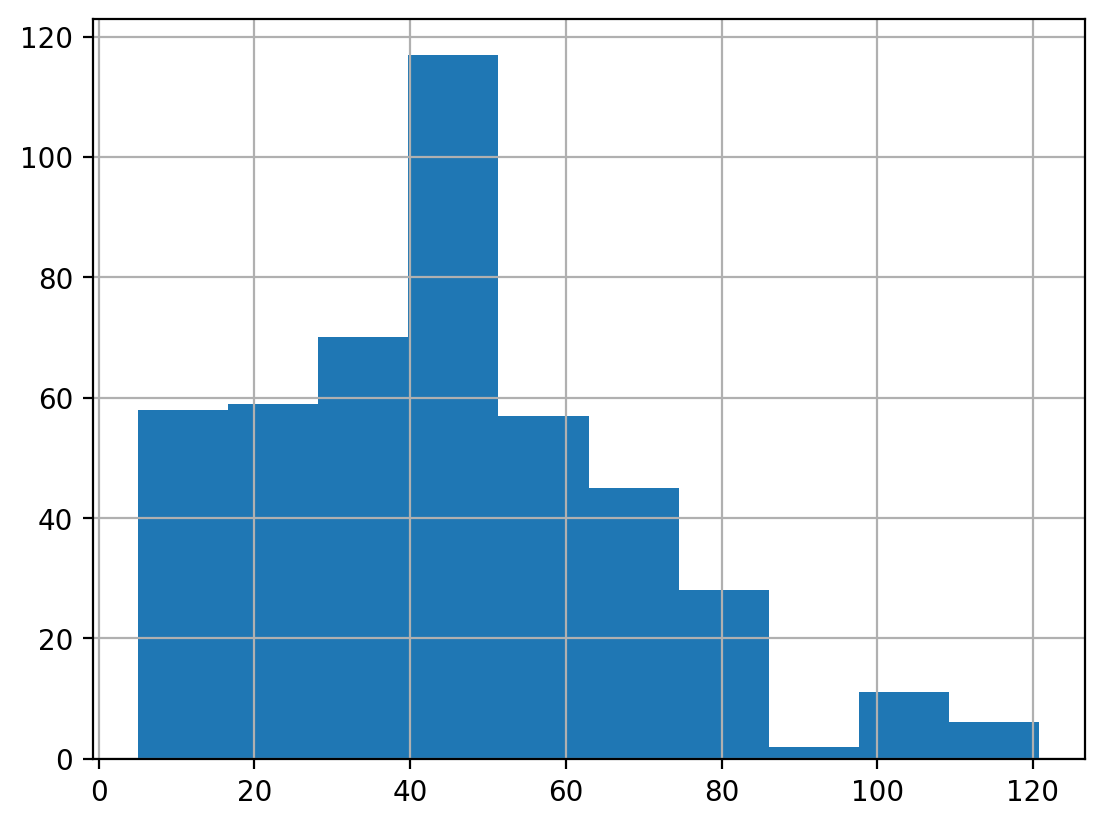

In [67]:
profiles_with_orders.query('channel == "WahooNetBanner" & payer == True')['revenue'].hist(label='55')

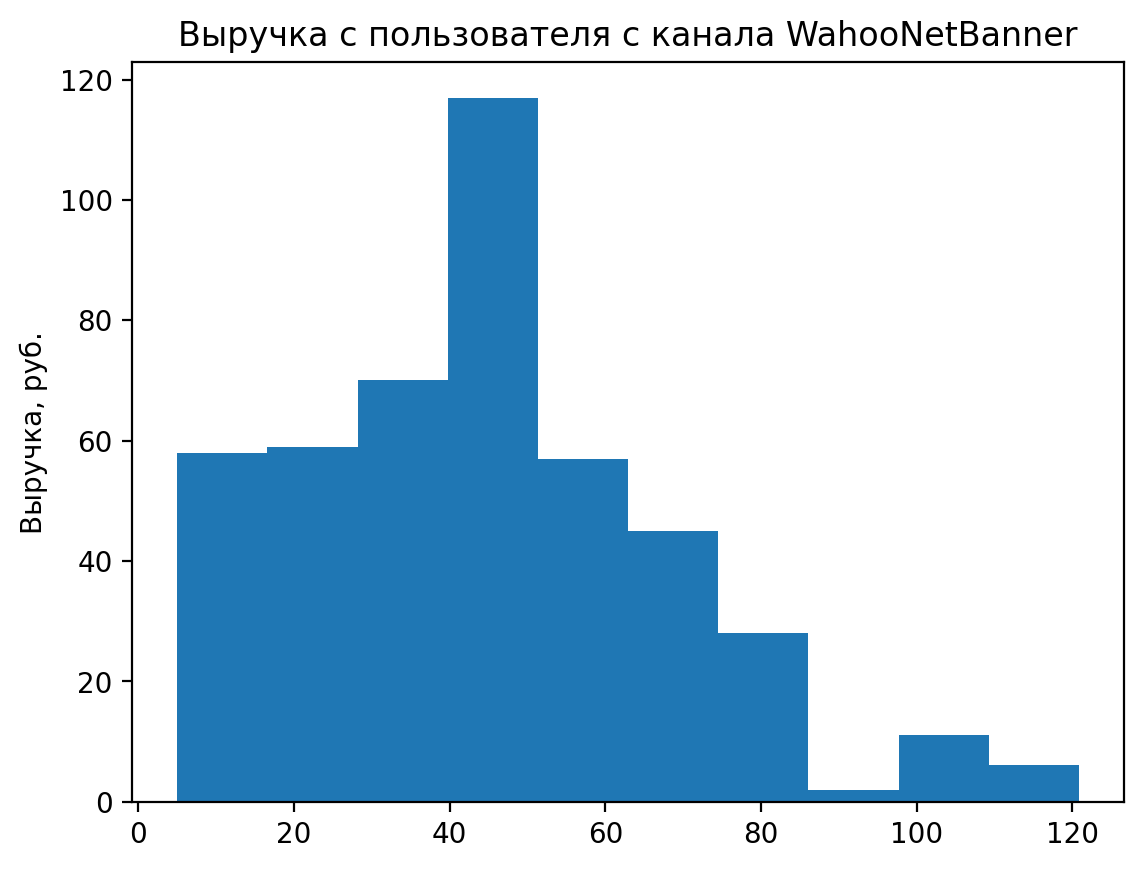

In [68]:
plt.figure()
profiles_with_orders.query('channel == "WahooNetBanner" & payer == True')['revenue'].plot(title='Выручка с пользователя с канала WahooNetBanner', kind='hist', ax=plt.subplot());
plt.ylabel('Выручка, руб.')
plt.show()

<Axes: >

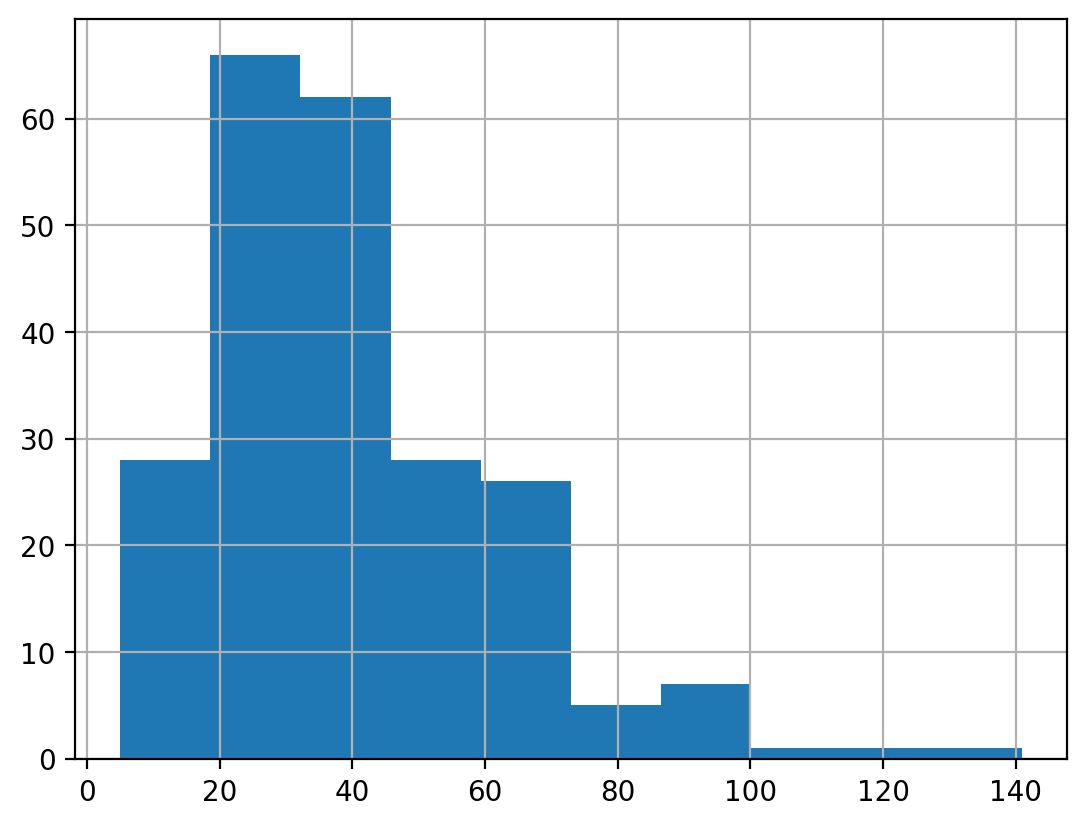

In [69]:
profiles_with_orders.query('channel == "lambdaMediaAds" & payer == True')['revenue'].hist()

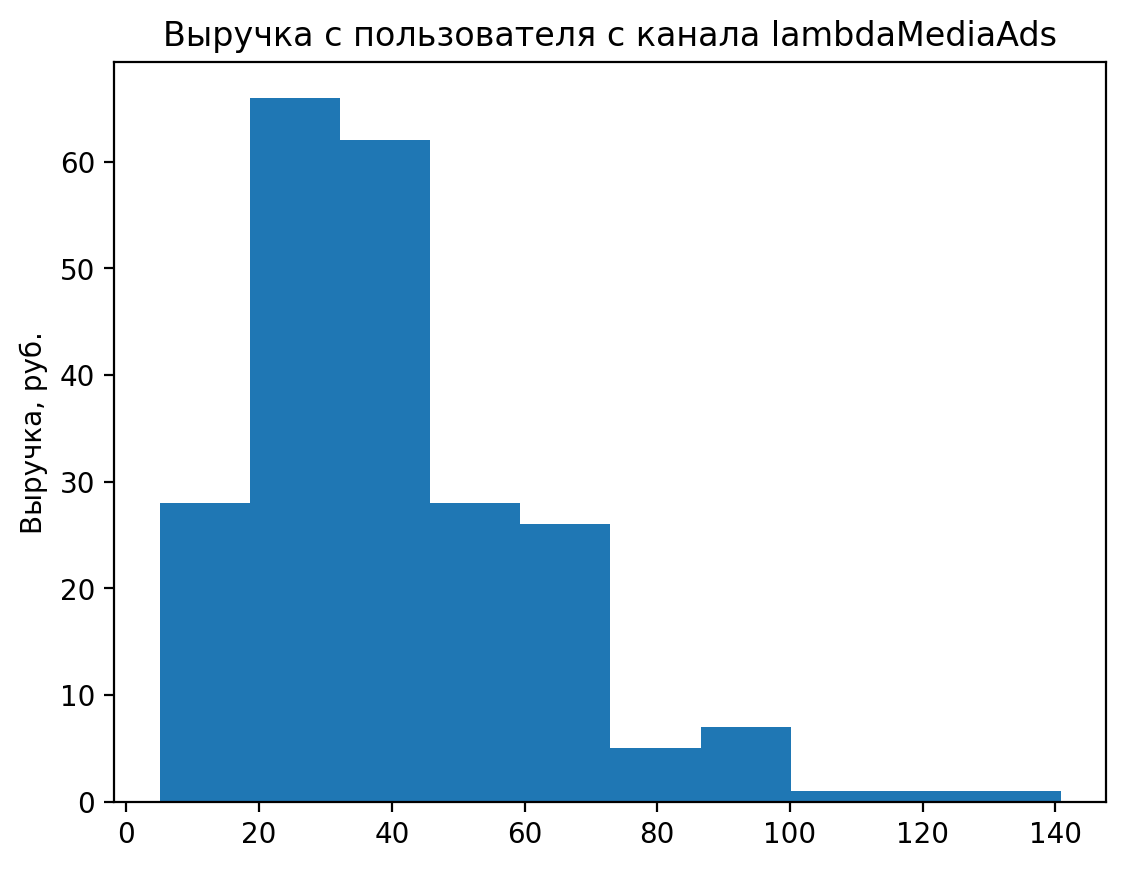

In [70]:
plt.figure()
profiles_with_orders.query('channel == "lambdaMediaAds" & payer == True')['revenue'].plot(title='Выручка с пользователя с канала lambdaMediaAds', kind='hist', ax=plt.subplot());
plt.ylabel('Выручка, руб.')
plt.show()

<Axes: >

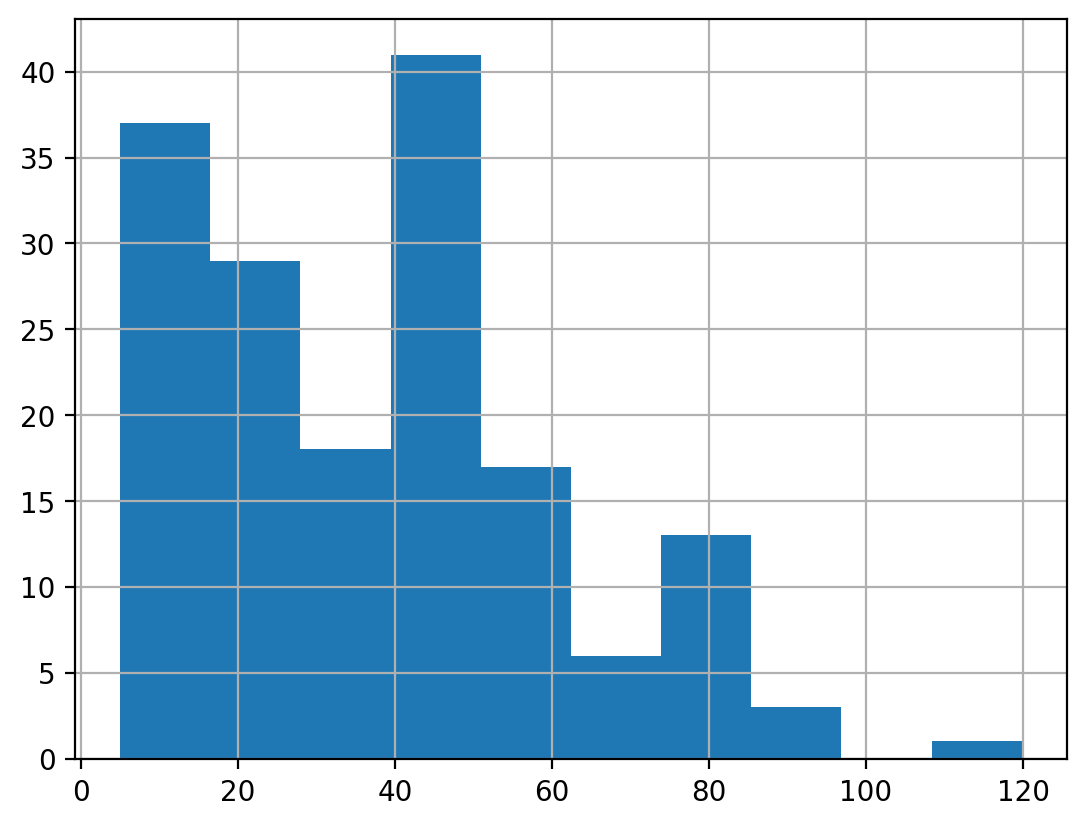

In [71]:
profiles_with_orders.query('channel == "YRabbit" & payer == True')['revenue'].hist()

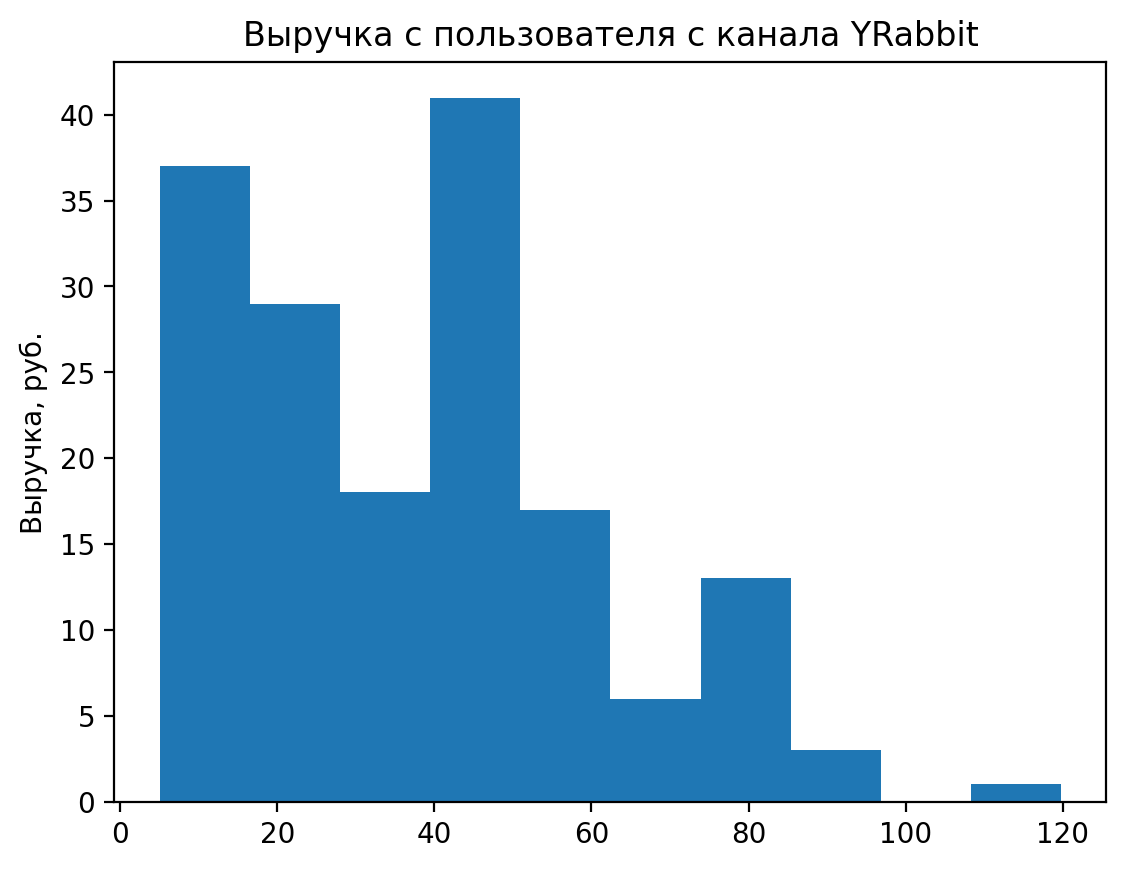

In [72]:
plt.figure()
profiles_with_orders.query('channel == "YRabbit" & payer == True')['revenue'].plot(title='Выручка с пользователя с канала YRabbit', kind='hist', ax=plt.subplot());
plt.ylabel('Выручка, руб.')
plt.show()

<Axes: >

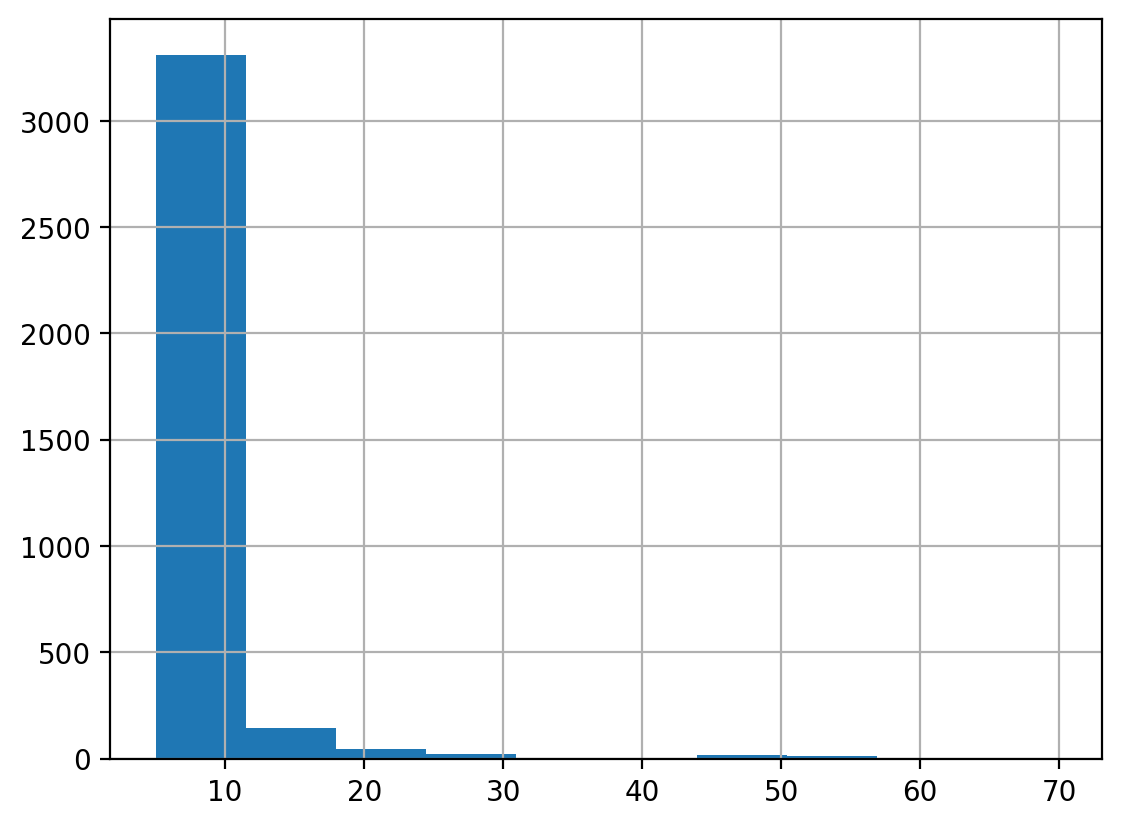

In [73]:
profiles_with_orders.query('channel == "FaceBoom" & payer == True')['revenue'].hist()

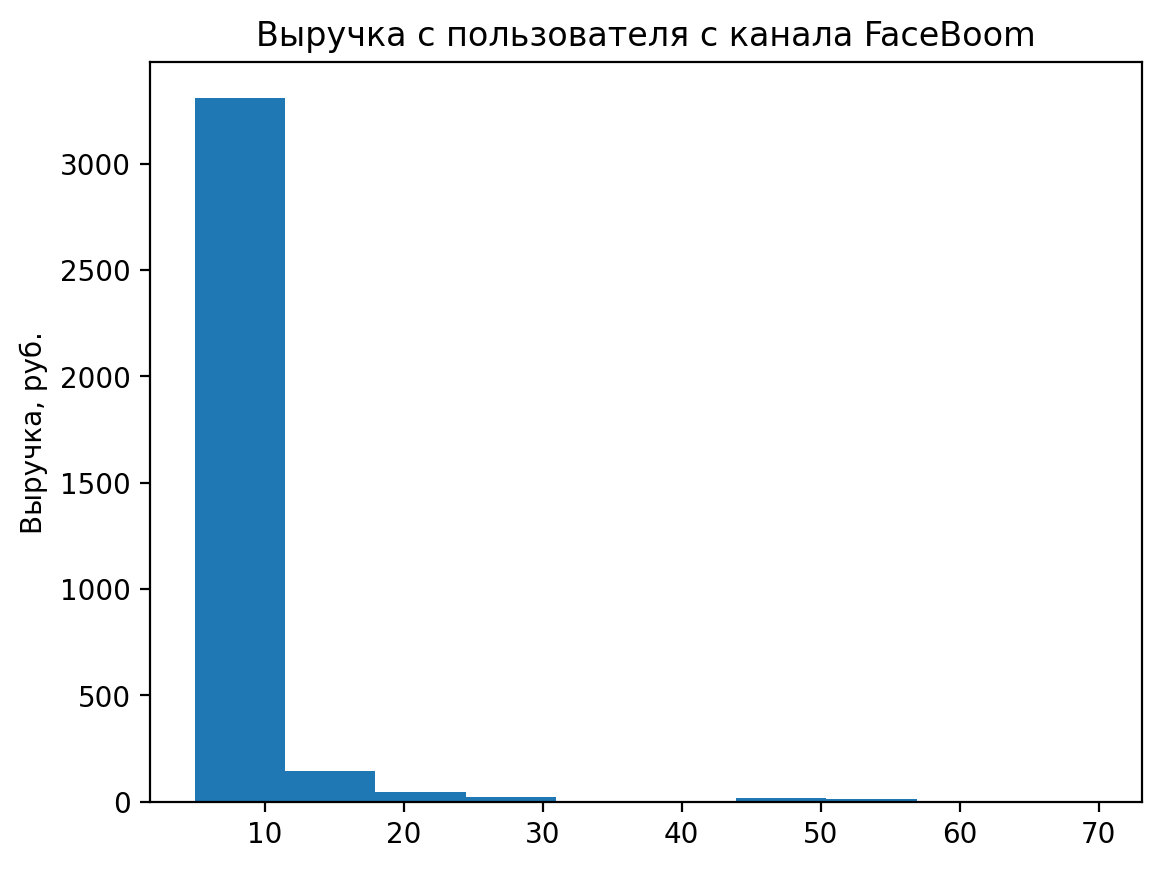

In [74]:
plt.figure()
profiles_with_orders.query('channel == "FaceBoom" & payer == True')['revenue'].plot(title='Выручка с пользователя с канала FaceBoom', kind='hist', ax=plt.subplot());
plt.ylabel('Выручка, руб.')
plt.show()

Пользователь с WahooNetBanner чаще всего тратит в приложении 50 рублей, с YRabbit от 10 до 50, с lambdaMediaAds от 20 до 50 рублей. Плательщик с FaceBoom тратит от 5 до 12 рублей.

Посмотрим распределенеие расходов на рекламу и доходов от продаж по регионам.

In [75]:
profiles_with_orders.groupby('region').agg({'acquisition_cost':'sum', 'revenue':'sum'}).sort_values(by='acquisition_cost', ascending=False)

acquisition_cost    revenue
region                                    
United States      90928.600000  149922.22
France              5075.973946   21554.78
UK                  5068.502819   24742.32
Germany             4424.223235   19743.56

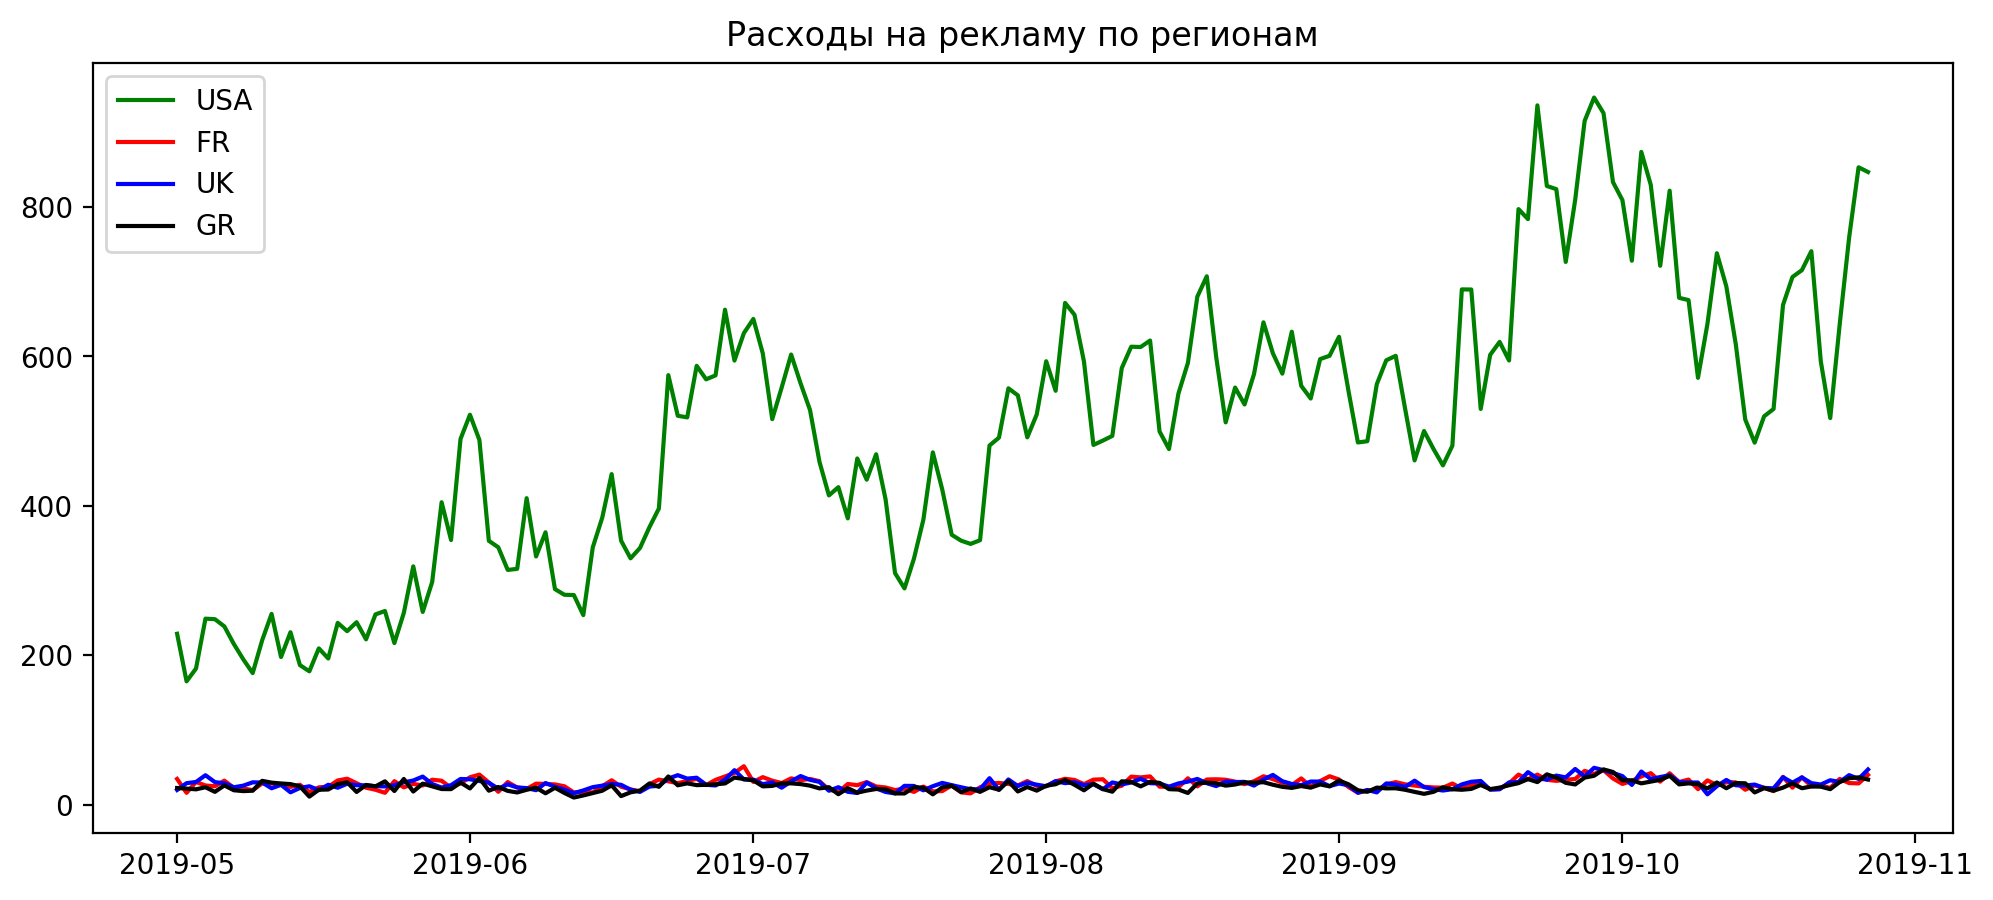

In [76]:
line_1 = profiles_with_orders.query('region == "United States"').groupby('dt')['acquisition_cost'].sum()
line_2 = profiles_with_orders.query('region == "France"').groupby('dt')['acquisition_cost'].sum()
line_3 = profiles_with_orders.query('region == "UK"').groupby('dt')['acquisition_cost'].sum()
line_4 = profiles_with_orders.query('region == "Germany"').groupby('dt')['acquisition_cost'].sum()

fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot()
 
ax1.plot(line_1, color = 'green', label = 'USA') 
ax1.plot(line_2, color = 'red', label = 'FR') 
ax1.plot(line_3, color = 'blue', label = 'UK') 
ax1.plot(line_4, color = 'black', label = 'GR') 
ax1.legend() 
ax1.set_title('Расходы на рекламу по регионам')
plt.show() 

<div class="alert alert-success">
<b>Комментарий ревьюера:</b>☀️
    
Для того, чтобы внимательнее изучить колебания расходов по регионам можно строить несколько графиков по размеру значений, здесь это не так критично, но вообще не особо понятно, как там дела с бюджетом всех стран кроме US
</div>

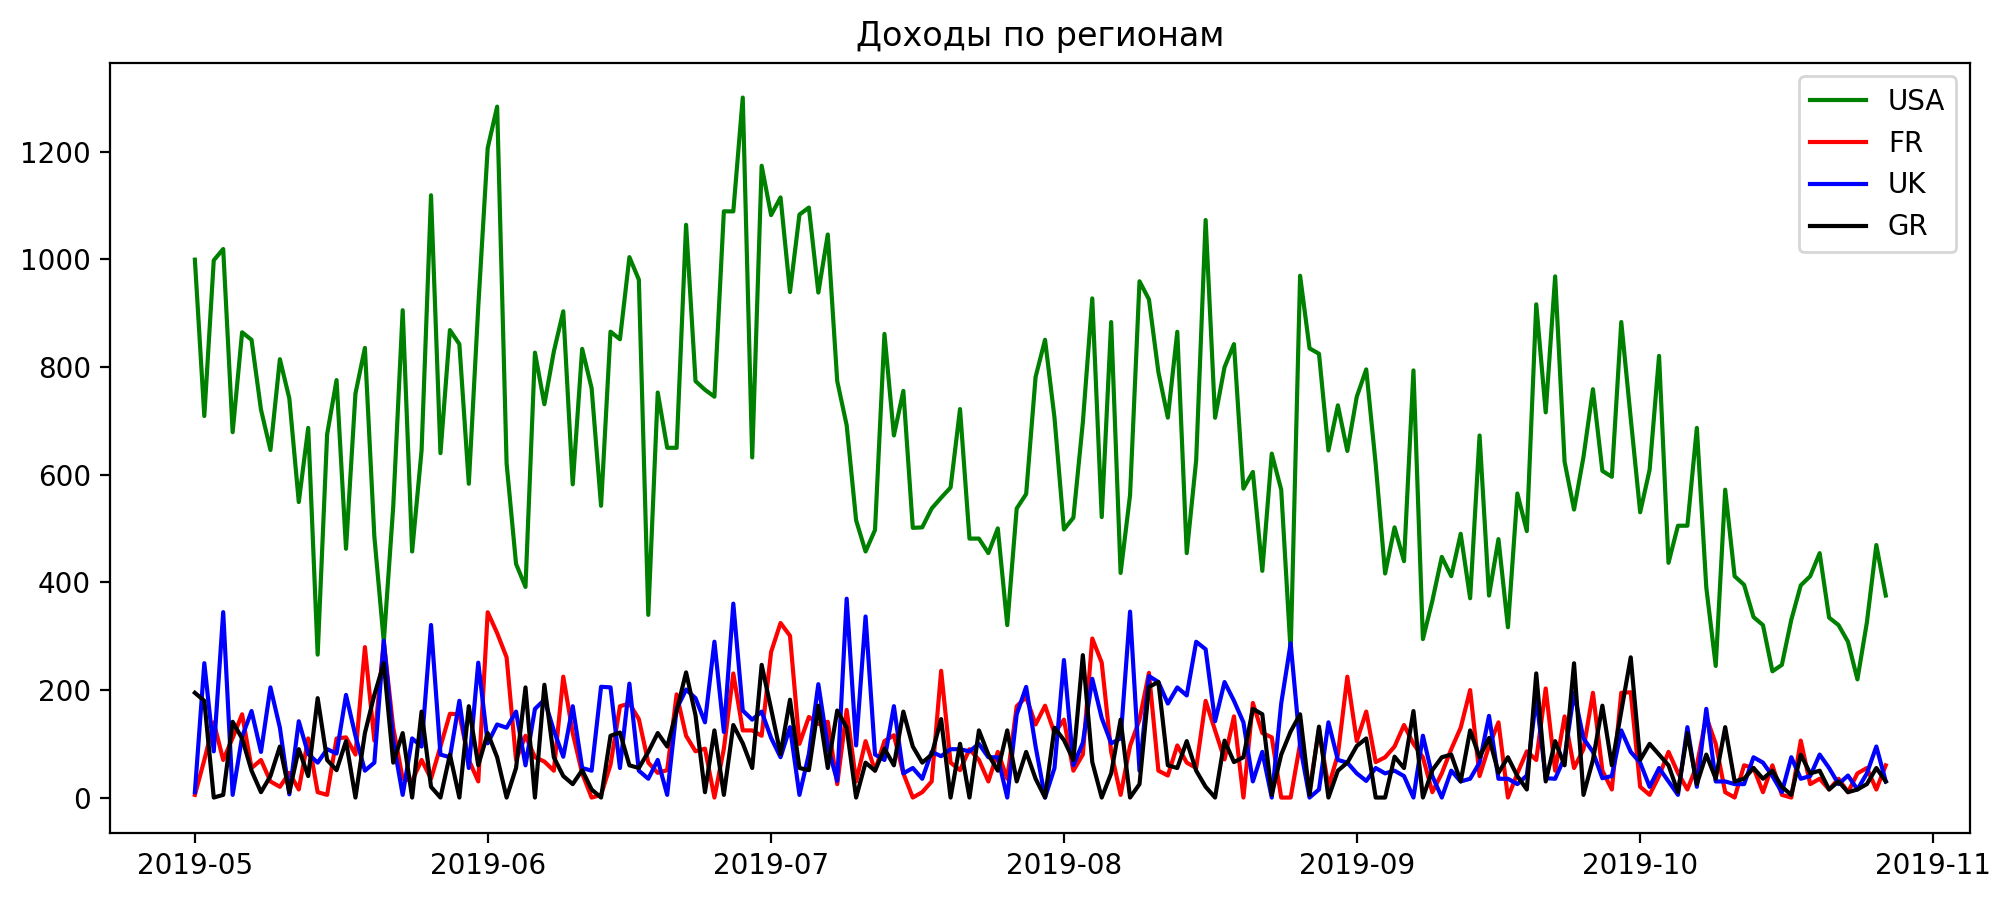

In [77]:
line_1 = profiles_with_orders.query('channel != "organic" & region == "United States"').groupby('dt')['revenue'].sum()
line_2 = profiles_with_orders.query('channel != "organic" & region == "France"').groupby('dt')['revenue'].sum()
line_3 = profiles_with_orders.query('channel != "organic" & region == "UK"').groupby('dt')['revenue'].sum()
line_4 = profiles_with_orders.query('channel != "organic" & region == "Germany"').groupby('dt')['revenue'].sum()

fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot()
 
ax1.plot(line_1, color = 'green', label = 'USA') 
ax1.plot(line_2, color = 'red', label = 'FR') 
ax1.plot(line_3, color = 'blue', label = 'UK') 
ax1.plot(line_4, color = 'black', label = 'GR') 
ax1.legend() 
ax1.set_title('Доходы по регионам')
plt.show() 

In [78]:
rev_reg = profiles_with_orders.query('channel != "organic"').groupby('region').agg({'acquisition_cost':'sum', 'revenue':'sum'}).sort_values(by='acquisition_cost', ascending=False)
rev_reg['acquisition_cost'] = round(rev_reg['acquisition_cost'],2)
rev_reg['revenue/cost'] = rev_reg['revenue'] / rev_reg['acquisition_cost']
rev_reg

acquisition_cost    revenue  revenue/cost
region                                                  
United States          90928.60  118764.49      1.306129
France                  5075.97   17064.22      3.361765
UK                      5068.50   19013.66      3.751339
Germany                 4424.22   14493.28      3.275895

Анализ затрат на рекламу по регионам выявил, что 86% расходов на рекламу уходят на привлечение пользователей в США. Графики показывают, что расходы на рекламу в Америке растут постоянно, а вот доходы в этом регионе в целом снижаются. 

Исключив из анализа доходы от пользователей "organic", на которых расходов на рекламу не было, мы получаем следующий результат: во Франции, Великобритании и Германии 1 рубль, потраченный на рекламу, приносит 3.27 - 3.75 рублей дохода, а в США только 1.31 руб. 

Явно реклама в Америке не приносит ожидаемой прибыли. Рассмотрим этот регион в разрезе платформ, на которых размещалась реклама. 

In [79]:
usa_channel = (profiles_with_orders.query('region == "United States" & channel != "organic"').groupby('channel').agg({'acquisition_cost':'sum','revenue':'sum'}).
sort_values(by='acquisition_cost', ascending=False))
usa_channel['revenue/cost'] = usa_channel['revenue'] / usa_channel['acquisition_cost']
usa_channel

acquisition_cost   revenue  revenue/cost
channel                                                 
TipTop                  54751.30  69574.76      1.270742
FaceBoom                32445.60  25637.66      0.790174
RocketSuperAds           1833.00  11598.32      6.327507
MediaTornado              954.48   5752.32      6.026653
YRabbit                   944.22   6201.43      6.567781

Из пяти платформ, на которых размещалась реклама в Америке, на первый взгляд, хорошие результаты показывают те три, затраты на которые были довольно низкими. А вот TipTop и FaceBoom, самые затратные, показывают очень низкий результат по платящим пользователям и их расходам в приложении.

Ниже рассмотрим показатели LTV, CAC и ROI по всем данным.

In [80]:
(profiles.query('channel != "organic"').pivot_table(index='month', columns='channel', values='acquisition_cost', aggfunc='mean').
 style.background_gradient(axis=0, cmap='Purples'))

In [81]:
(profiles_with_orders.query('channel != "organic"').pivot_table(index='month', columns='channel', values='revenue', aggfunc='mean').
 style.background_gradient(axis=0, cmap='Purples'))

## Окупаемость рекламы для привлечения пользователей

### Общая окупаемость рекламы

Проанализируем окупаемость рекламы в общем с помощью LTV и ROI.

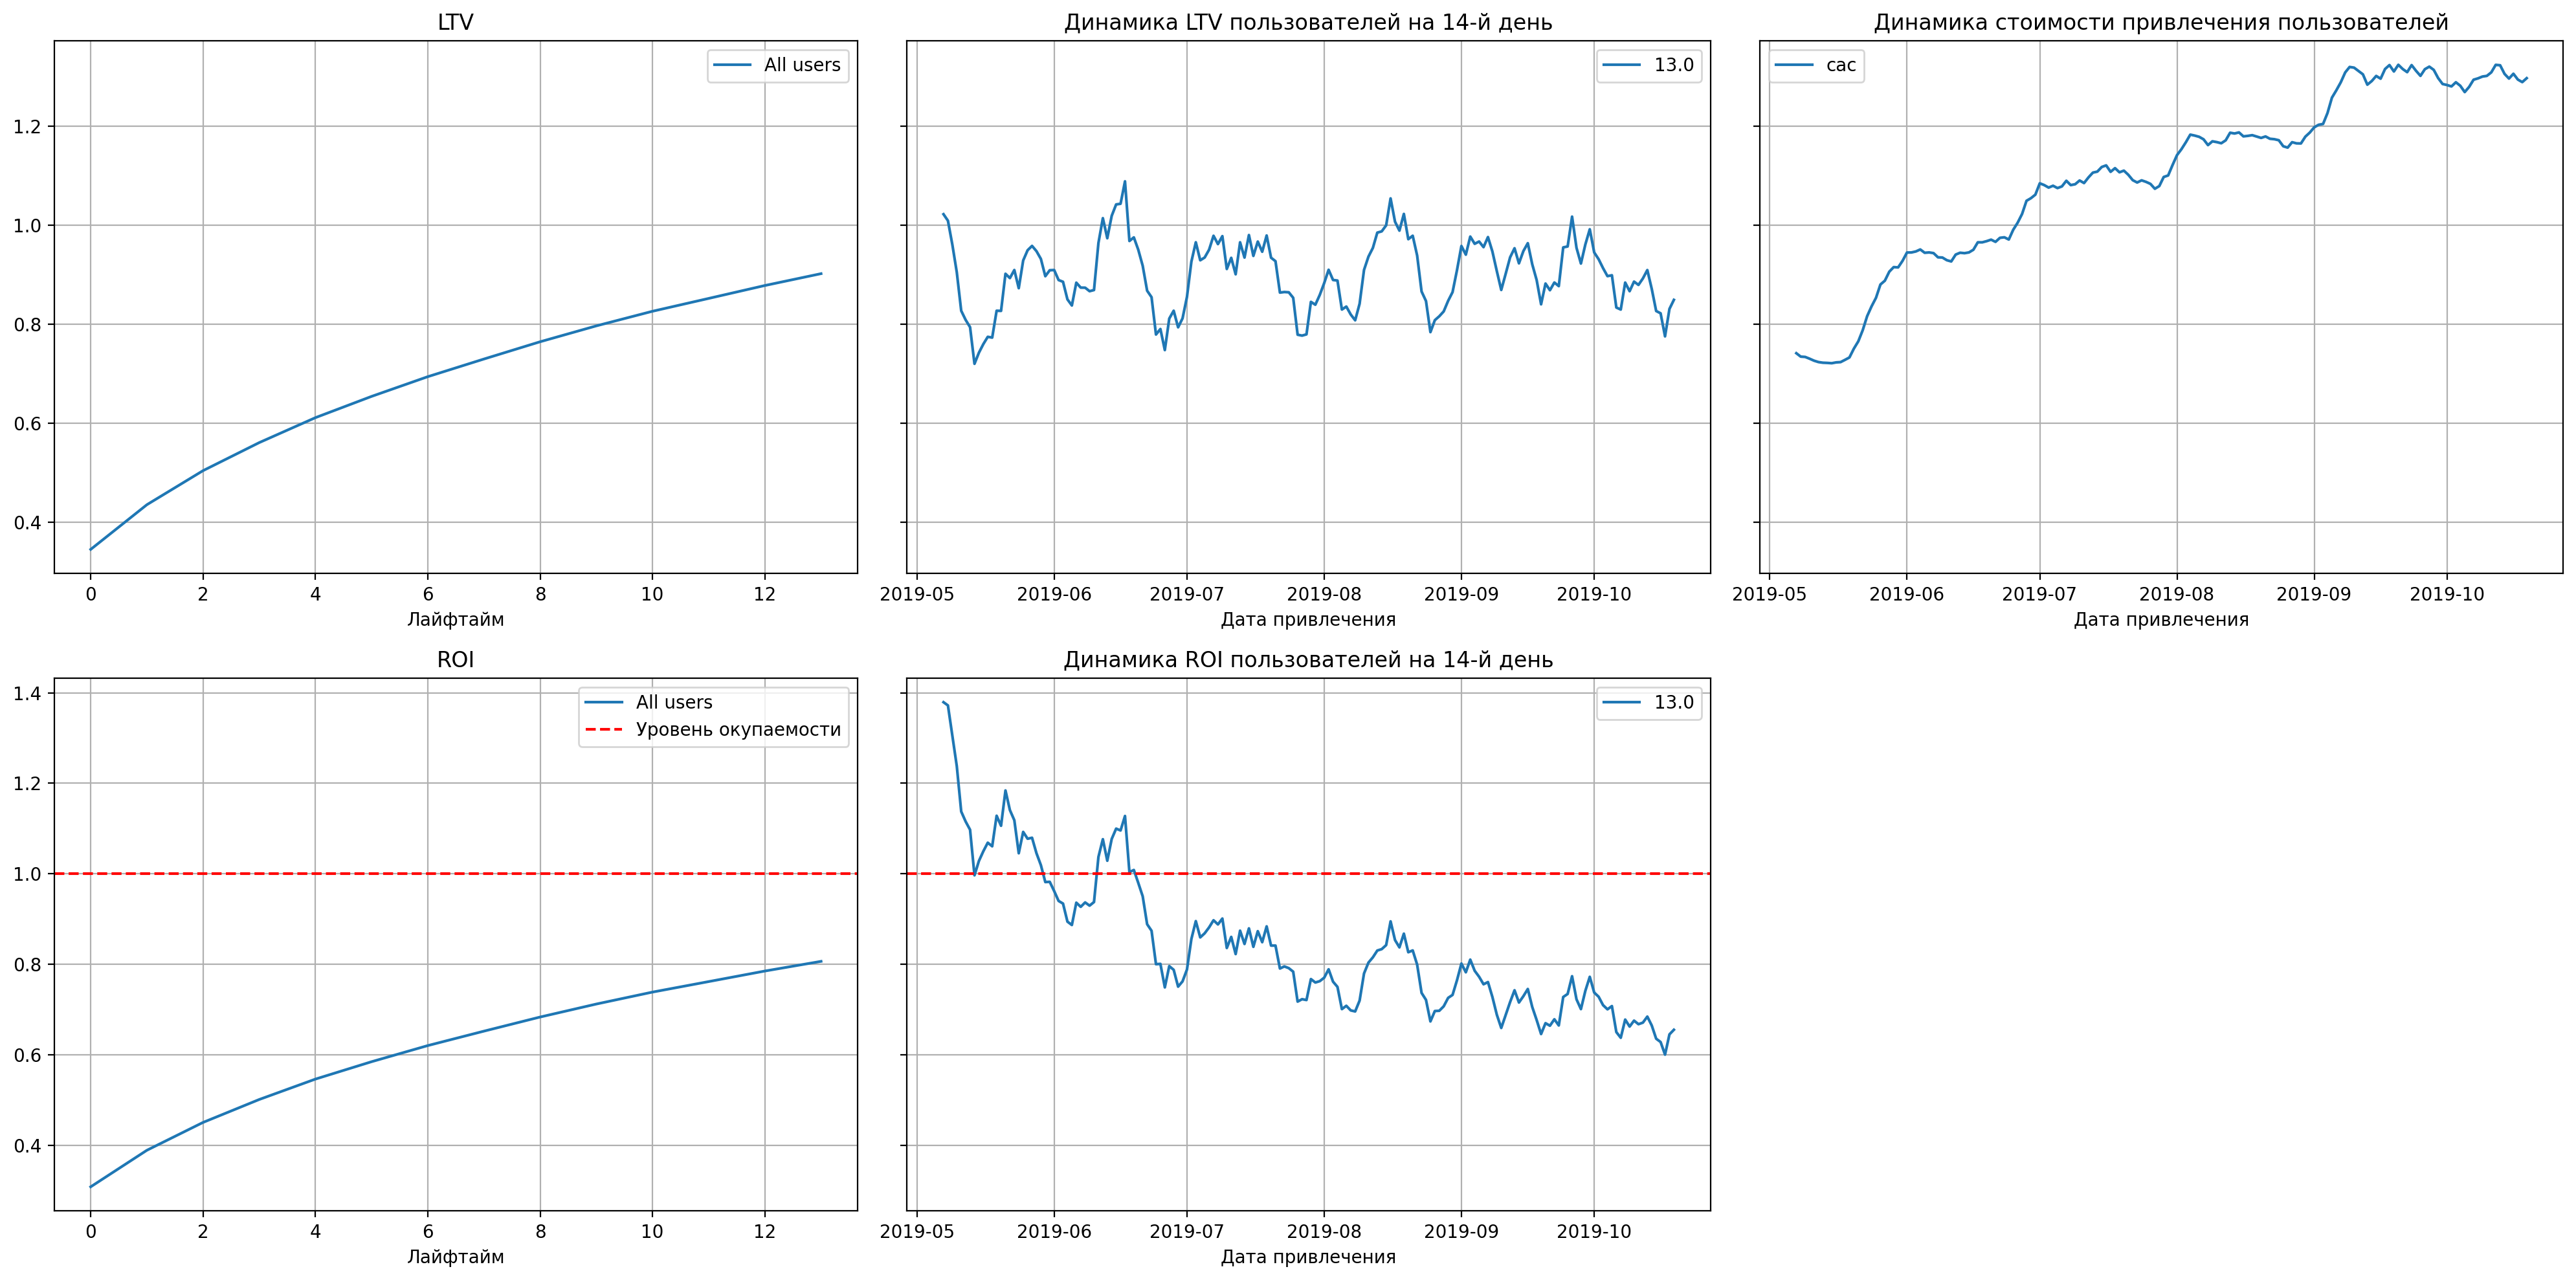

In [82]:
profiles = profiles.query('channel != "organic"')
observation_date = datetime(2019,11,1).date()
horizon_days = 14

# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

In [83]:
ltv_grouped.drop(columns=['cohort_size',0]).reset_index()


cohort       1.0       2.0      3.0       4.0       5.0      6.0  \
0  All users  0.435754  0.504507  0.56109  0.611436  0.654368  0.69414   

        7.0       8.0       9.0      10.0     11.0      12.0     13.0  
0  0.729778  0.764619  0.796665  0.826152  0.85207  0.878116  0.90203

In [84]:
roi_grouped.drop(columns=['cohort_size',0]).reset_index()

cohort       cac       1.0       2.0       3.0       4.0      5.0  \
0  All users  1.117794  0.389834  0.451341  0.501962  0.547002  0.58541   

        6.0       7.0       8.0       9.0      10.0      11.0      12.0  \
0  0.620991  0.652873  0.684043  0.712711  0.739091  0.762278  0.785579   

       13.0  
0  0.806974

По графикам можно сделать такие выводы:
Реклама не окупается. ROI в конце периода на уровне 80%. CAC растет, расходы на рекламу увеличивались почти весь анализируемый период. График динамики ROI показывает, что на уровне окупаемости расходы на рекламу не были с середины июля. Чтобы разобраться в причинах, пройдём по всем доступным характеристикам пользователей — стране, источнику и устройству первого посещения.

### Окупаемость рекламы с разбивкой по устройствам

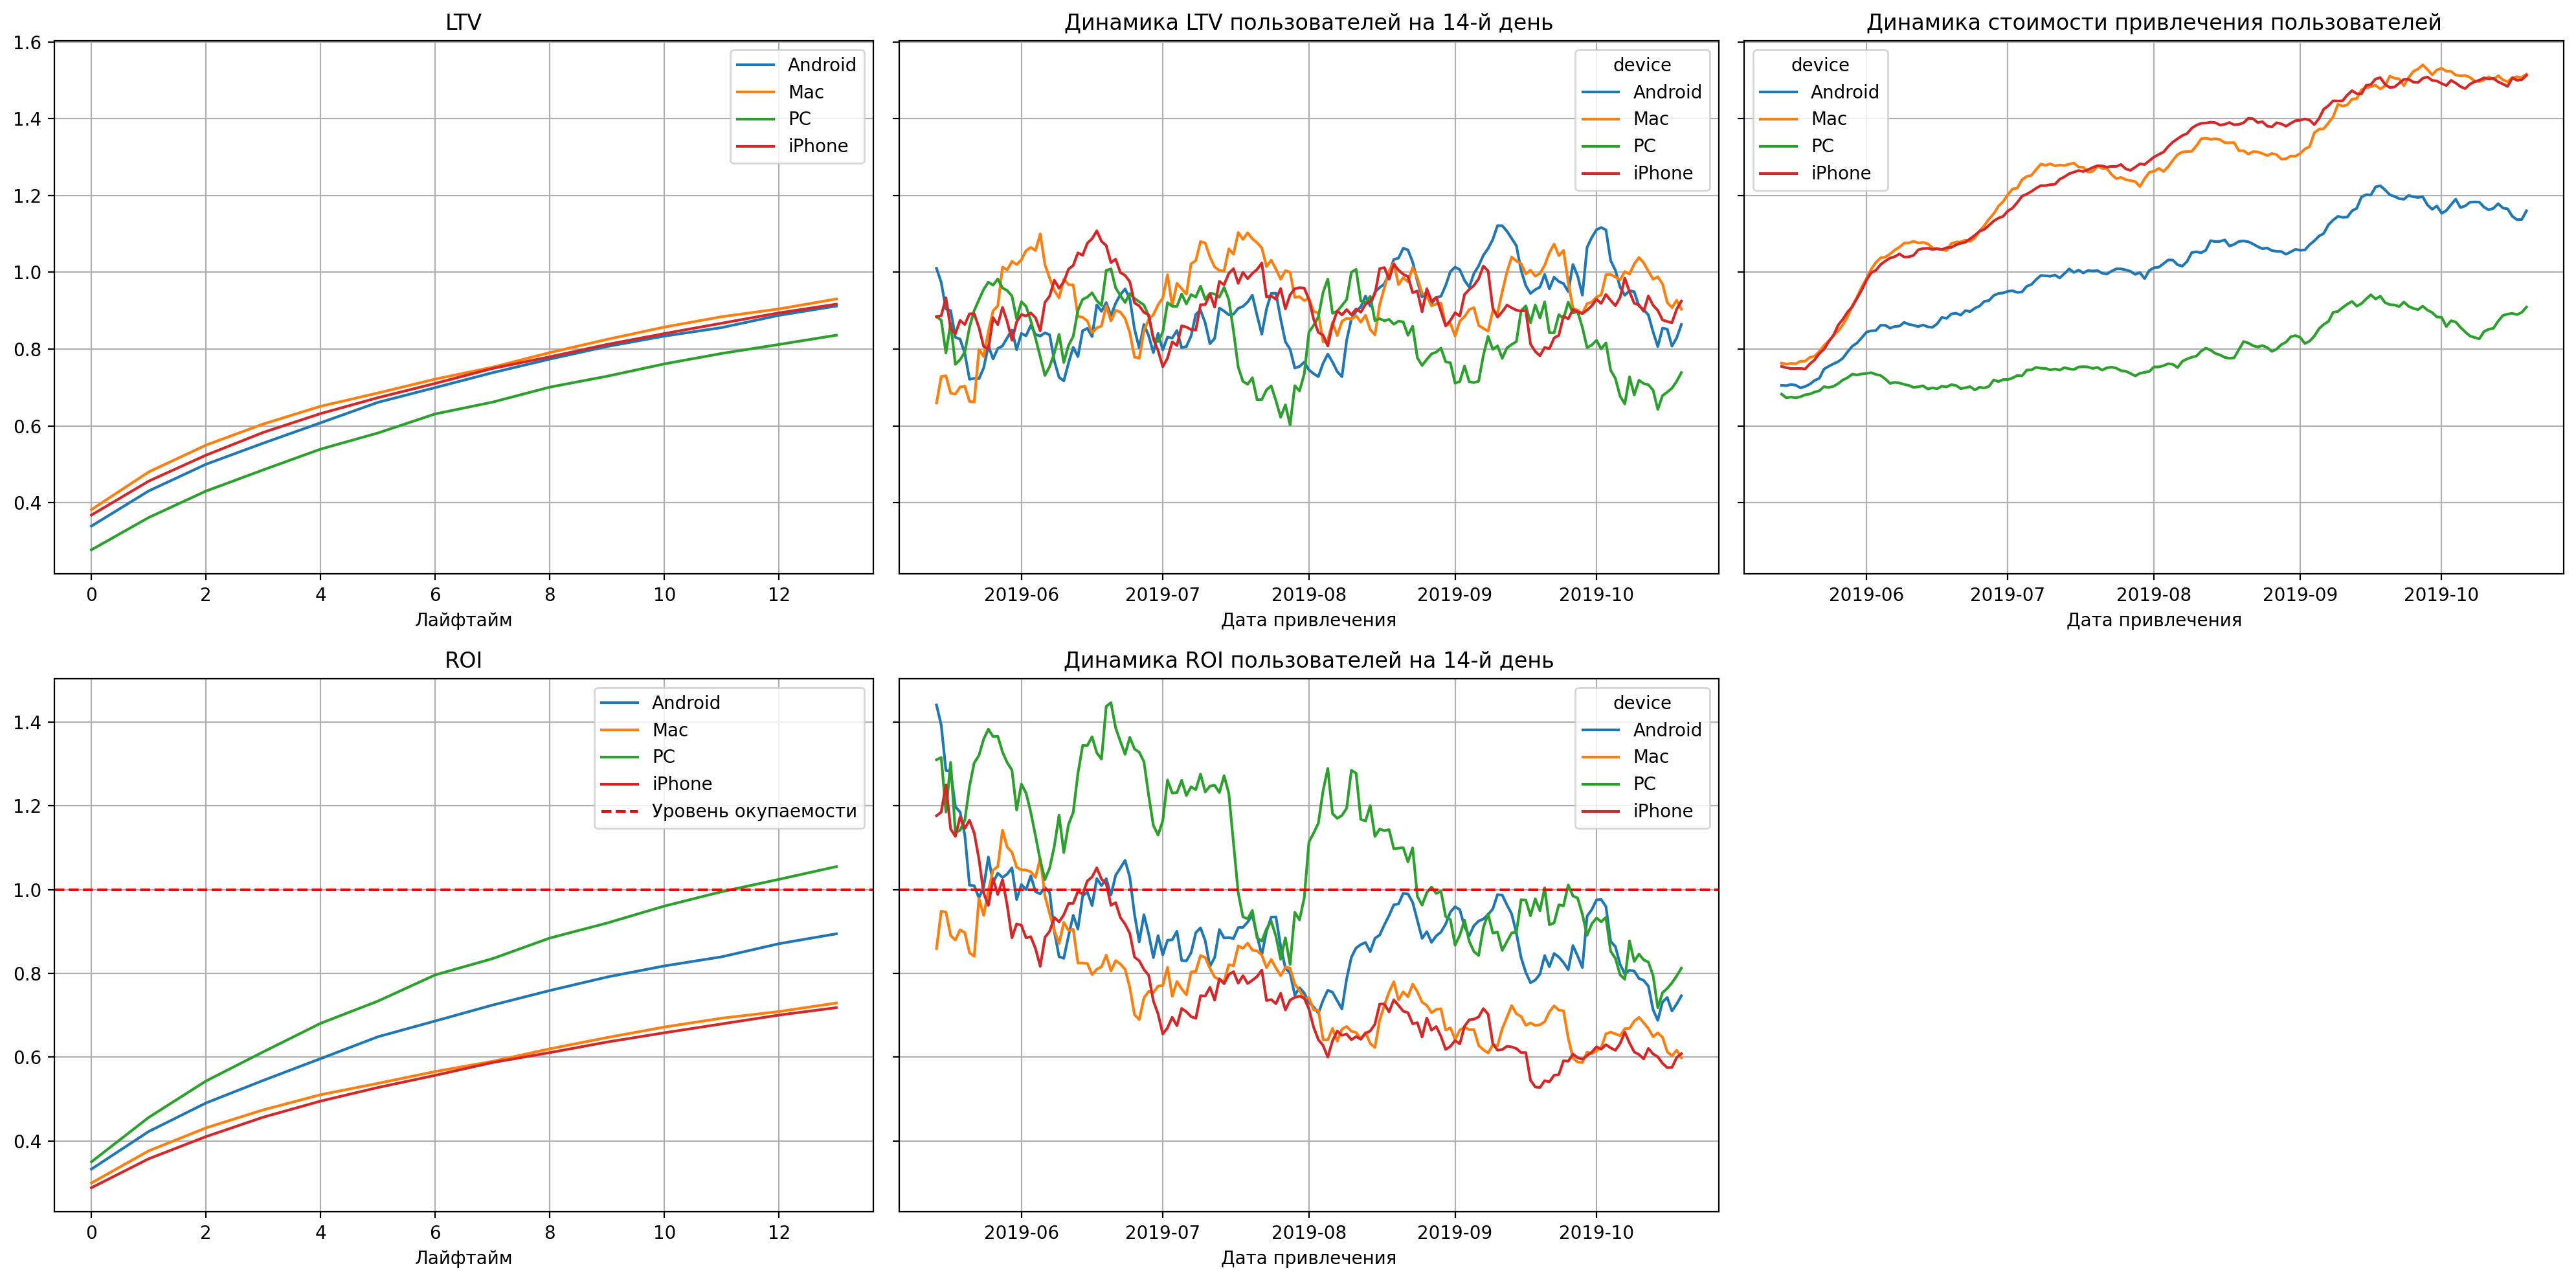

In [85]:
profiles = profiles.query('channel != "organic"')
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

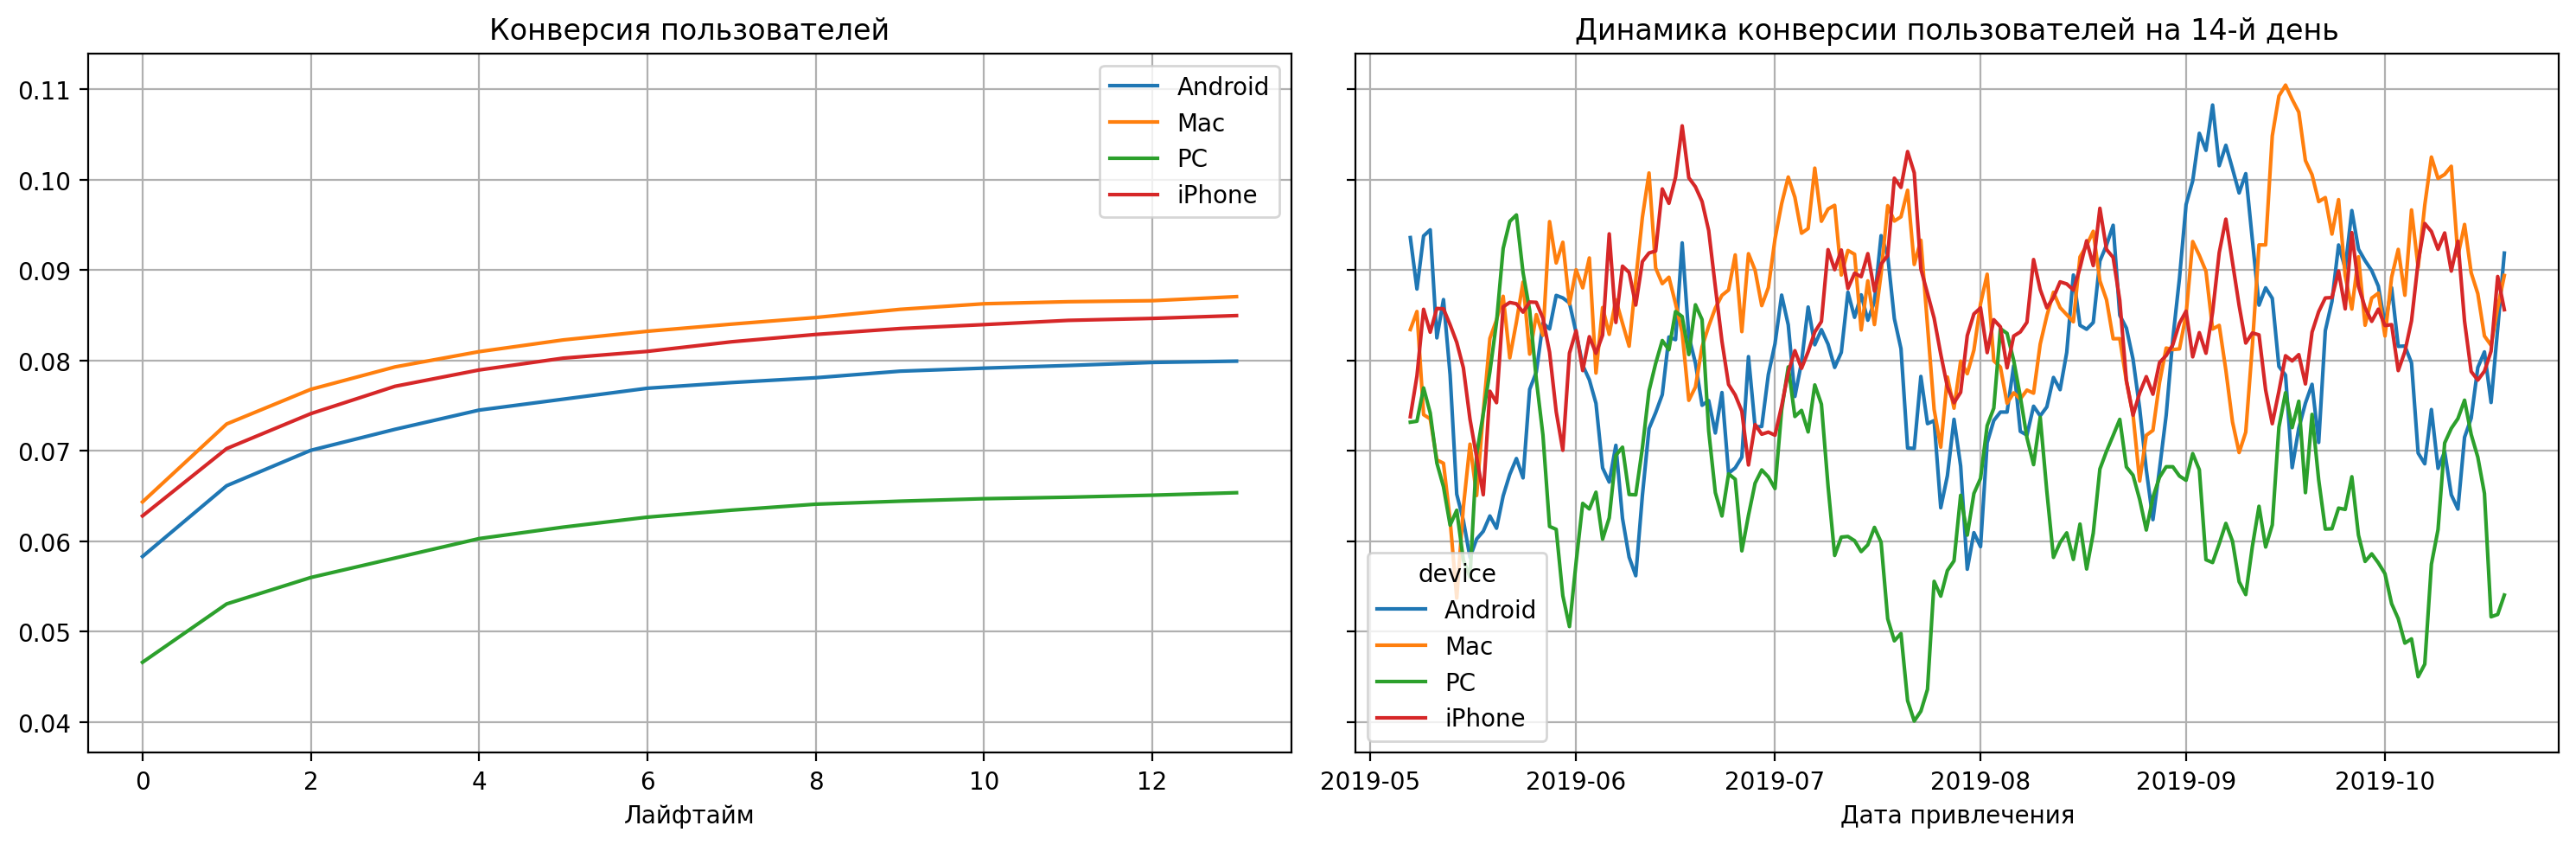

In [86]:
# смотрим конверсию с разбивкой по устройствам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

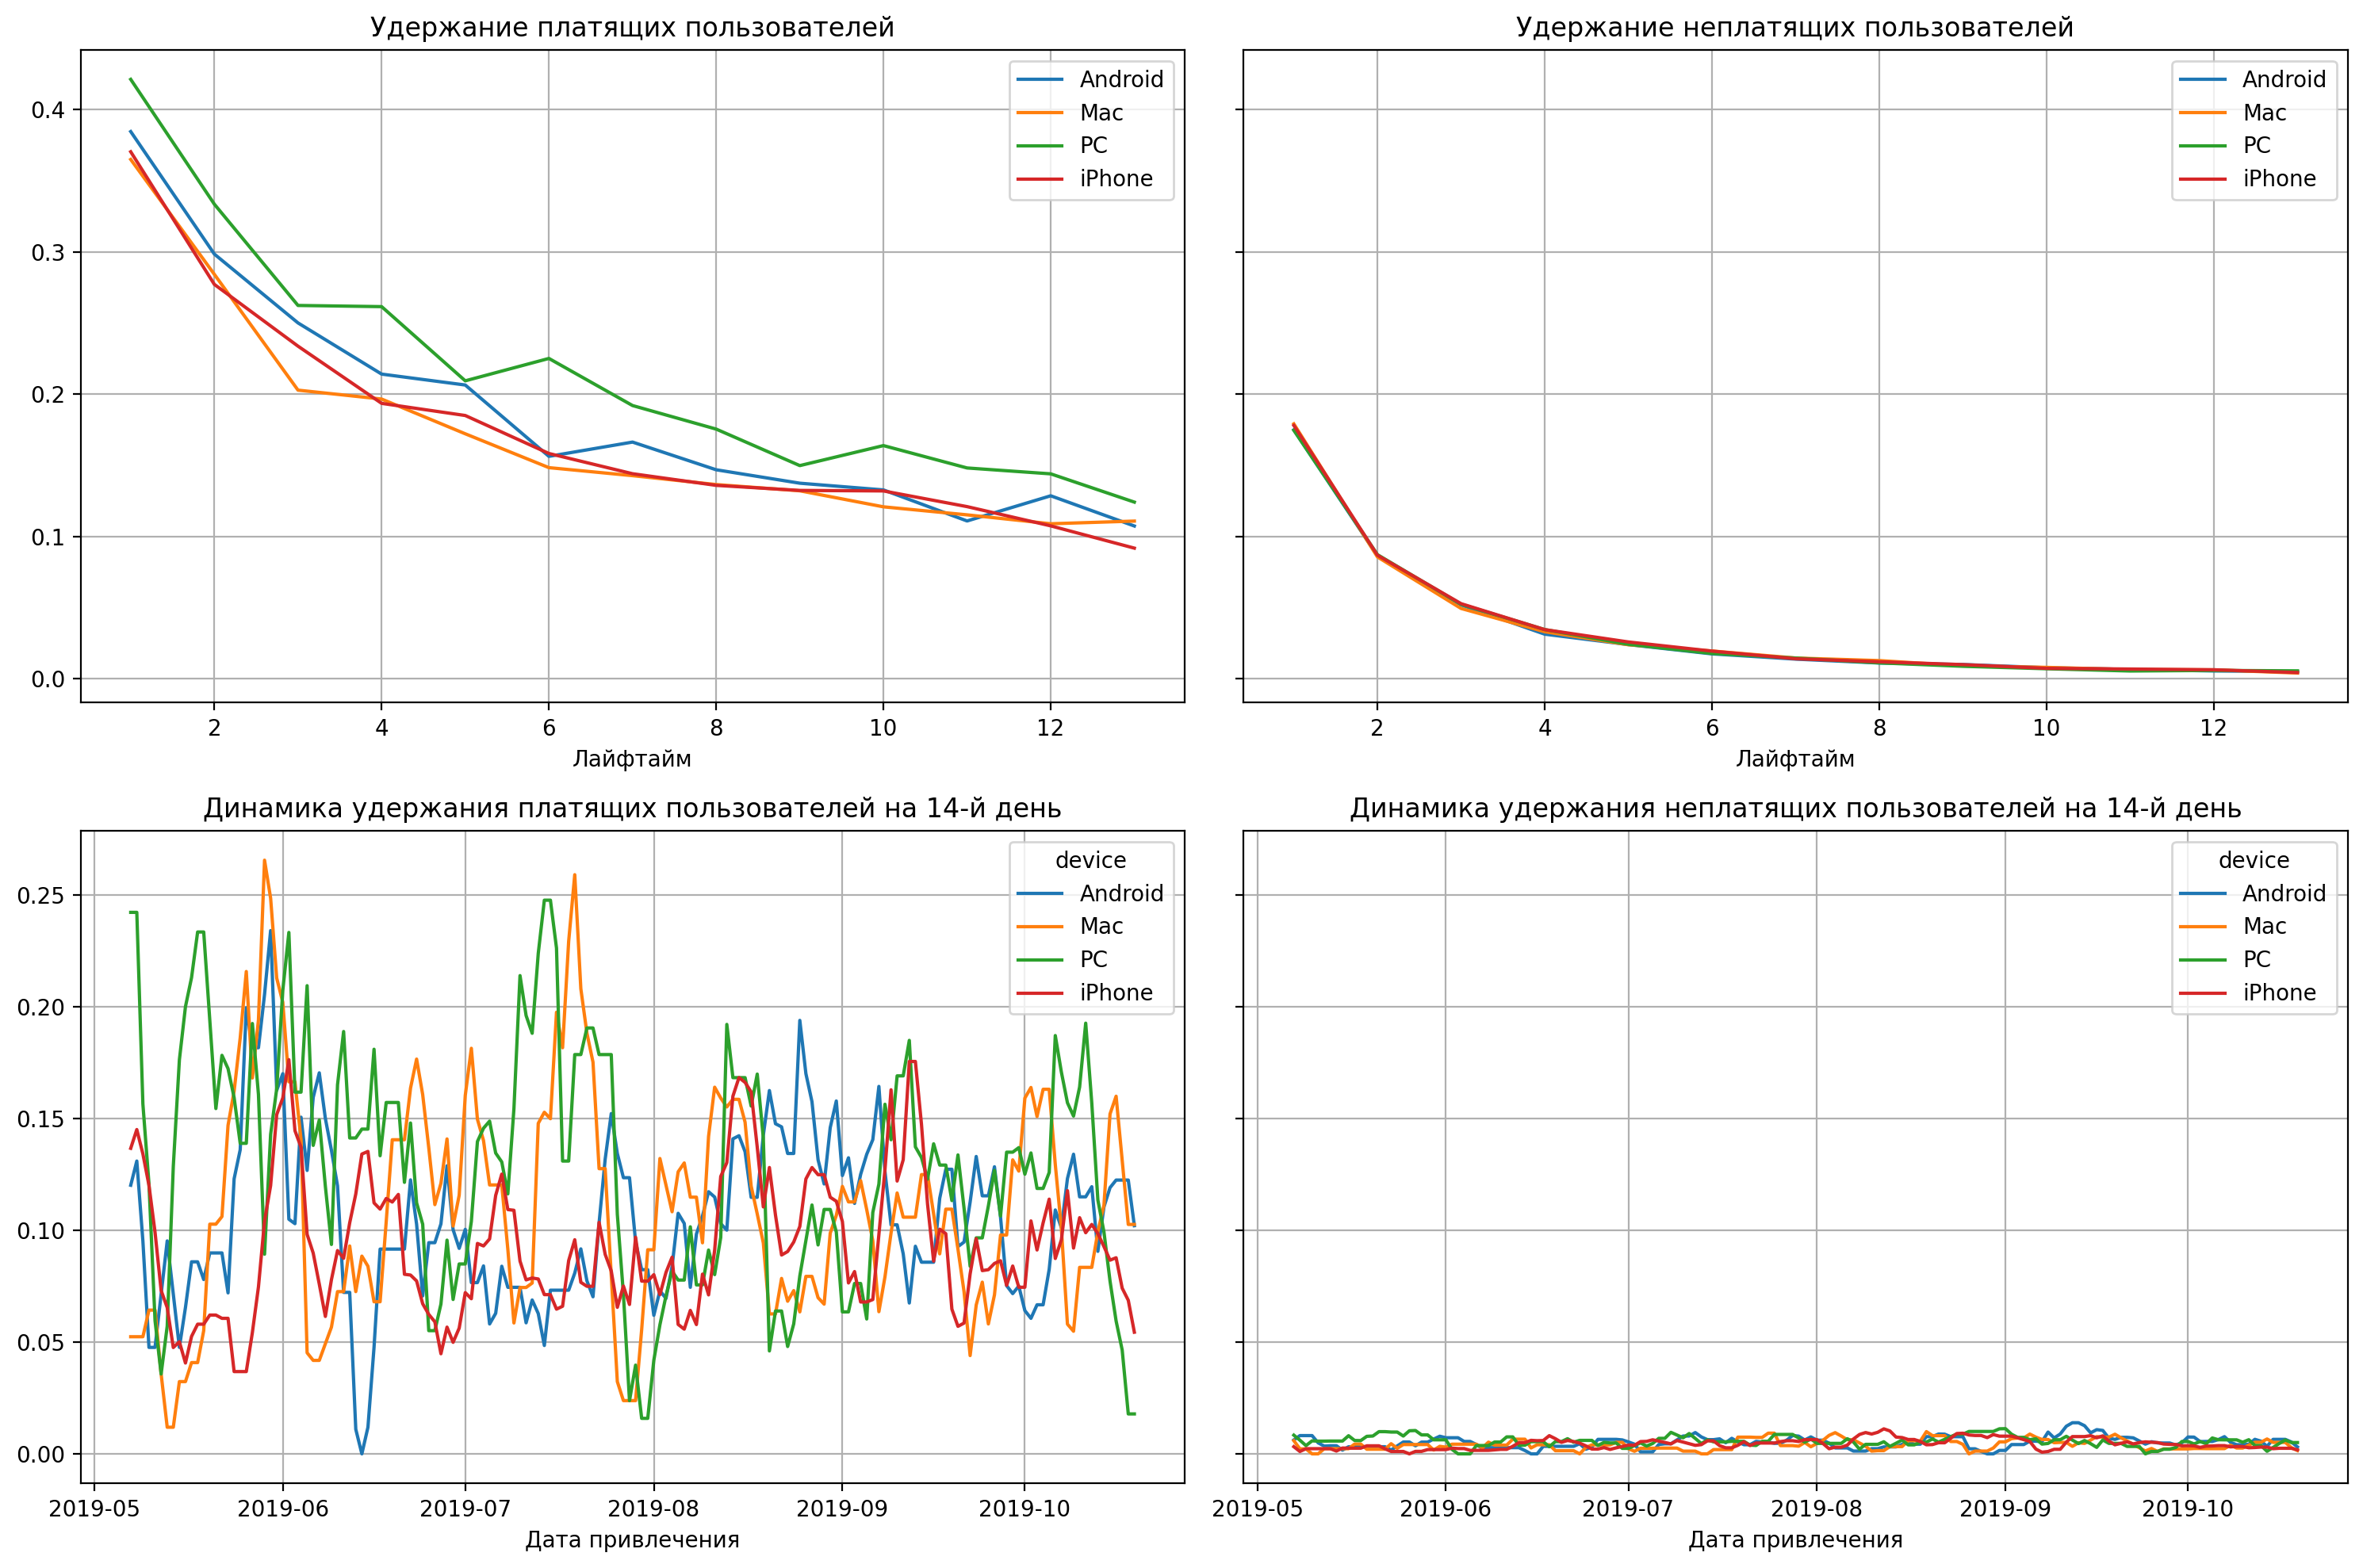

In [87]:
# смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

In [88]:
profiles_with_orders.query('channel != "organic"').groupby('device').agg({'acquisition_cost':'sum', 'revenue':'sum'}).sort_values(by='acquisition_cost', ascending=False)

acquisition_cost   revenue
device                             
iPhone       43678.788251  61702.53
Mac          24094.537878  33407.61
Android      22460.629159  40474.99
PC           15263.344712  33750.52

In [89]:
profiles_with_orders.query('channel != "organic" & device == "PC"').groupby('channel').agg({'acquisition_cost':'sum', 'revenue':'sum'}).sort_values(by='revenue', ascending=False)

acquisition_cost  revenue
channel                                      
WahooNetBanner           2052.616493  8500.09
TipTop                   5681.471760  7597.11
LeapBob                   714.807823  3943.54
lambdaMediaAds            620.523528  3685.45
OppleCreativeMedia        873.926694  3376.87
FaceBoom                 3349.226836  2693.91
AdNonSense               1577.353344  1646.02
RocketSuperAds            190.368256   997.04
YRabbit                   104.414113   693.67
MediaTornado               98.635866   616.82

Единственная окупаемая платформа - РС, при том, что у нее самые низкие показатели LTV и конверсии. Видимо, это связано с тем, что на рекламу на РС тратили меньше всего, это и вывело РС в лидеры по окупаемости. 

Платформы iPhone, Мас и Android при высокой конверсии показывают почти такое же удержание пользователей, как РС. У них выше LTV, но и расходы на рекламу очень высокие, и ROI ниже уровня окупаемости на протяжении почти всего лайфтайм пользователя.

### Окупаемость рекламы с разбивкой по странам

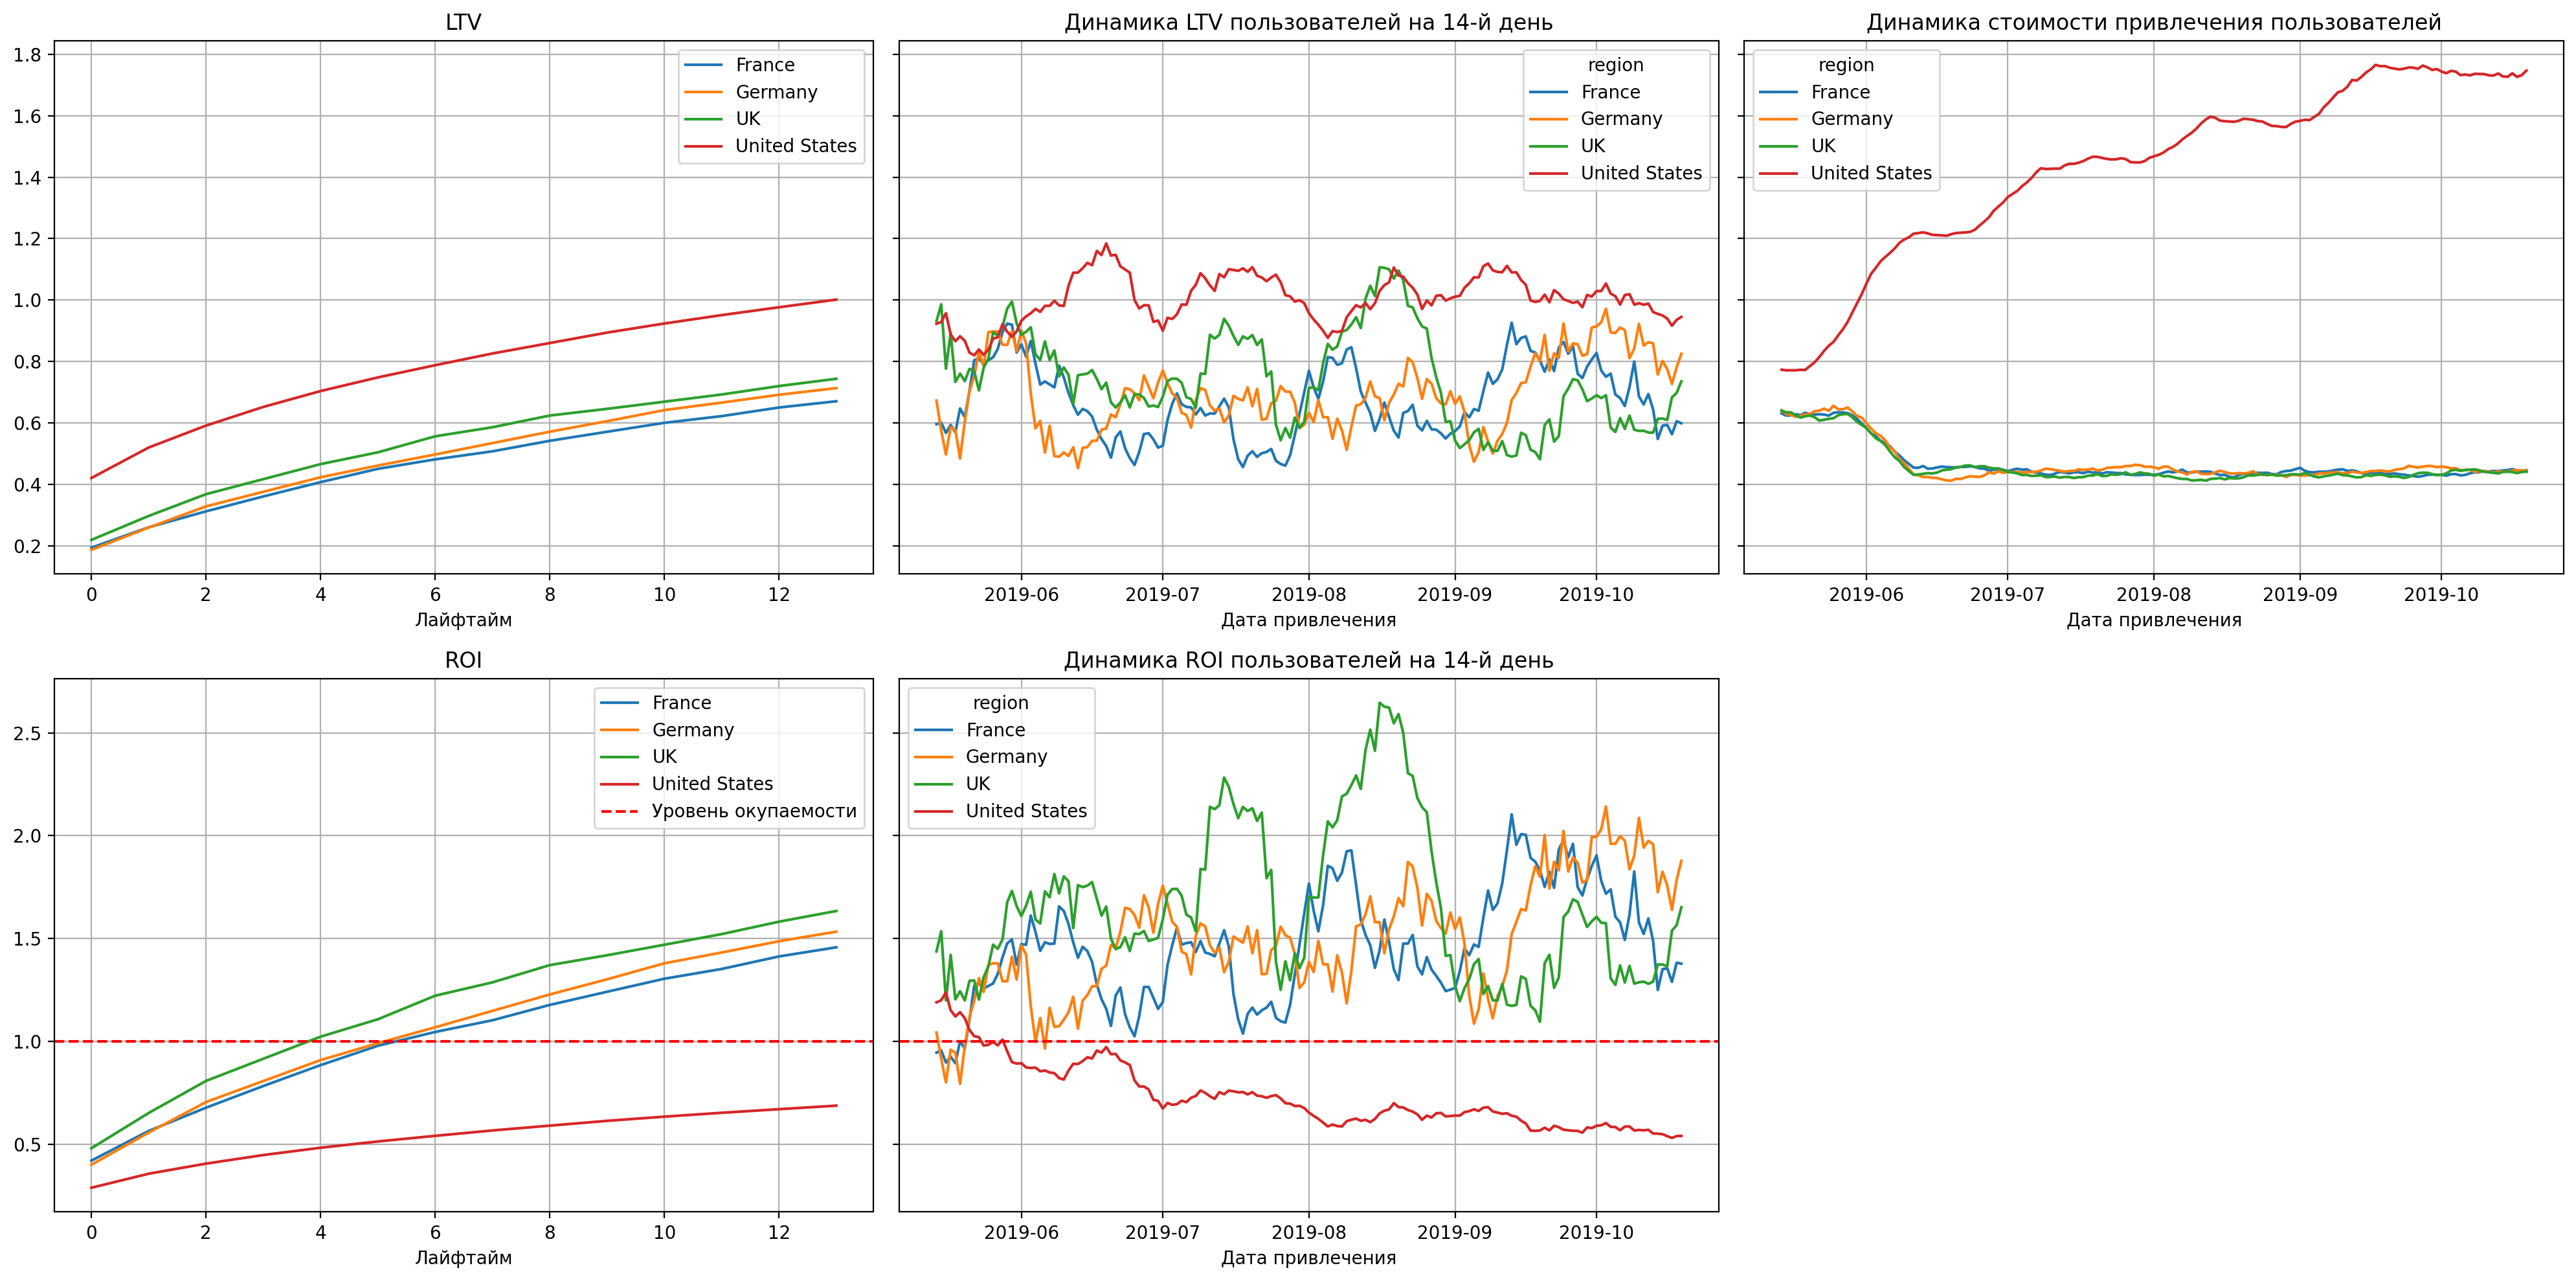

In [90]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

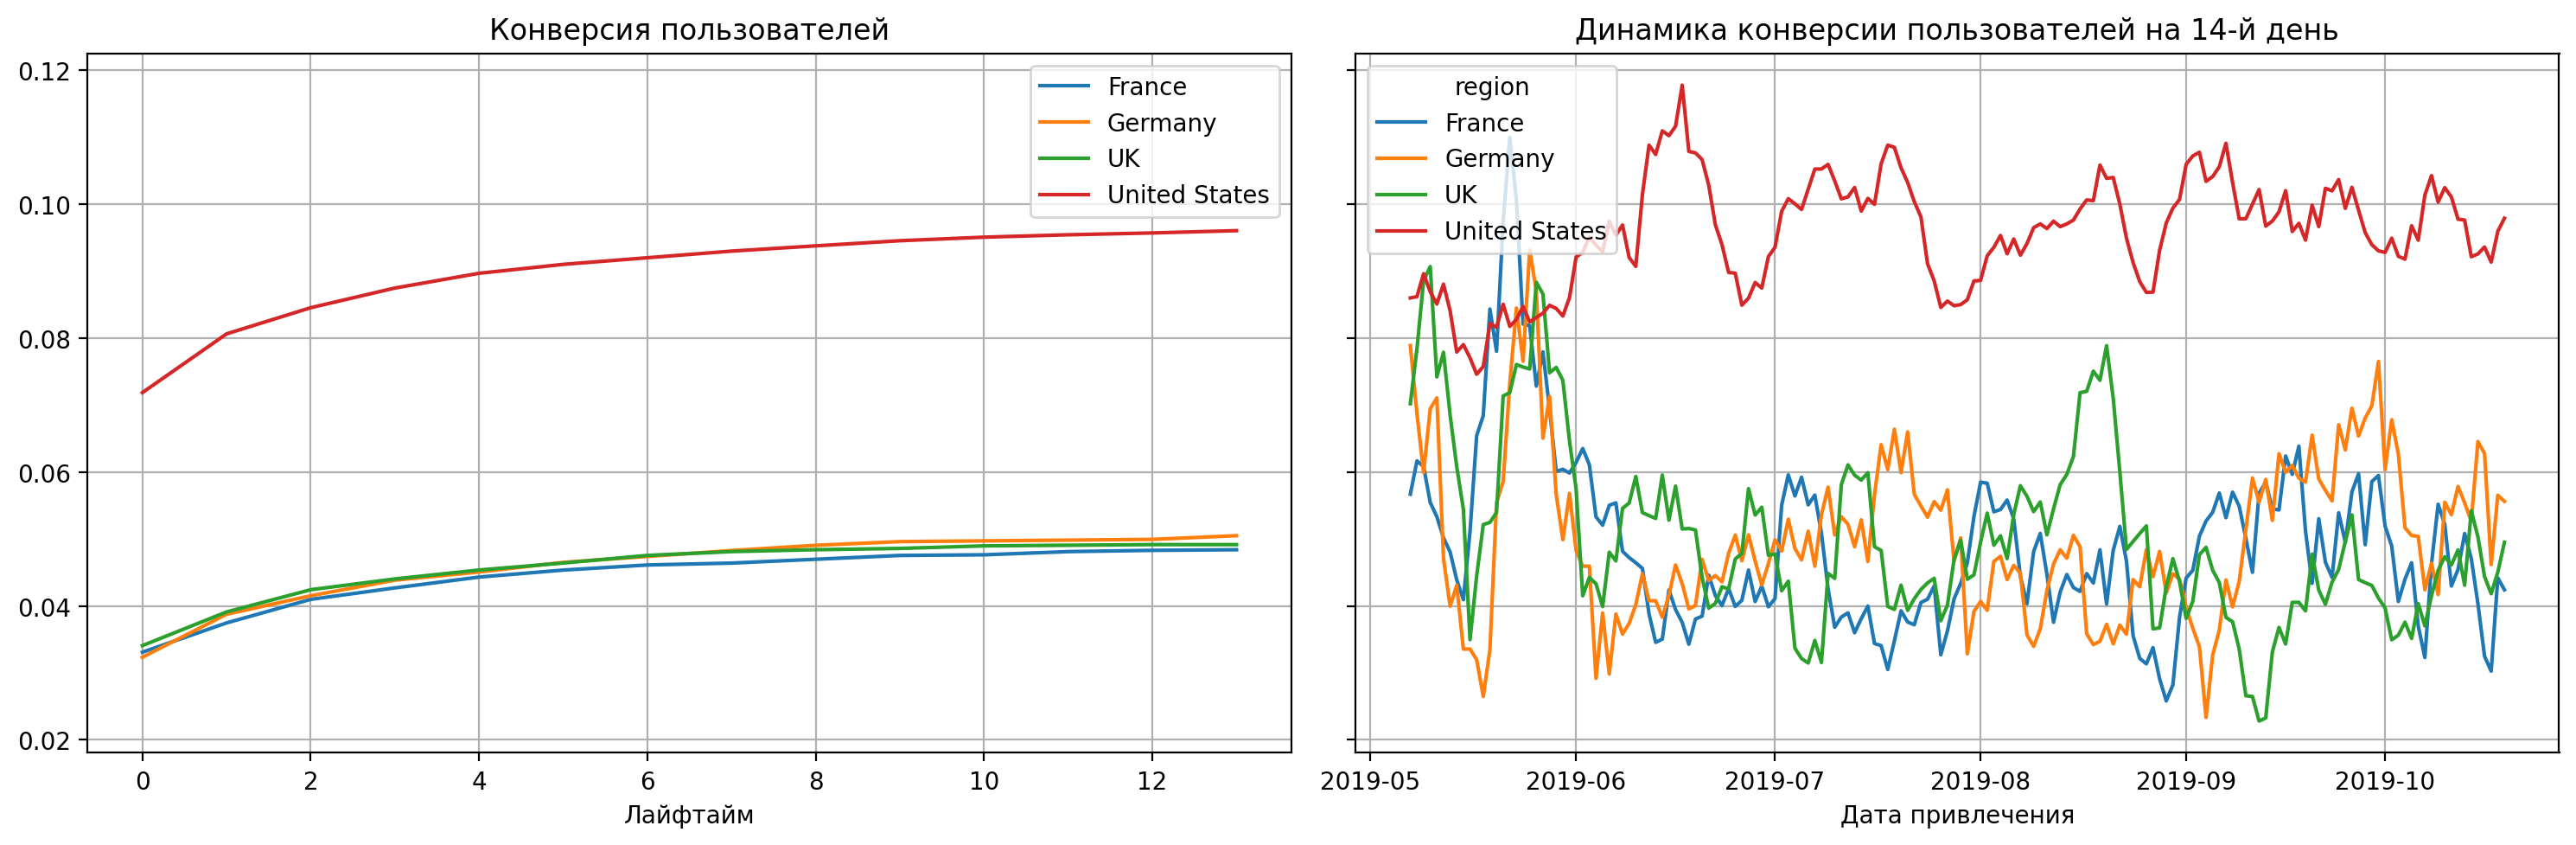

In [91]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

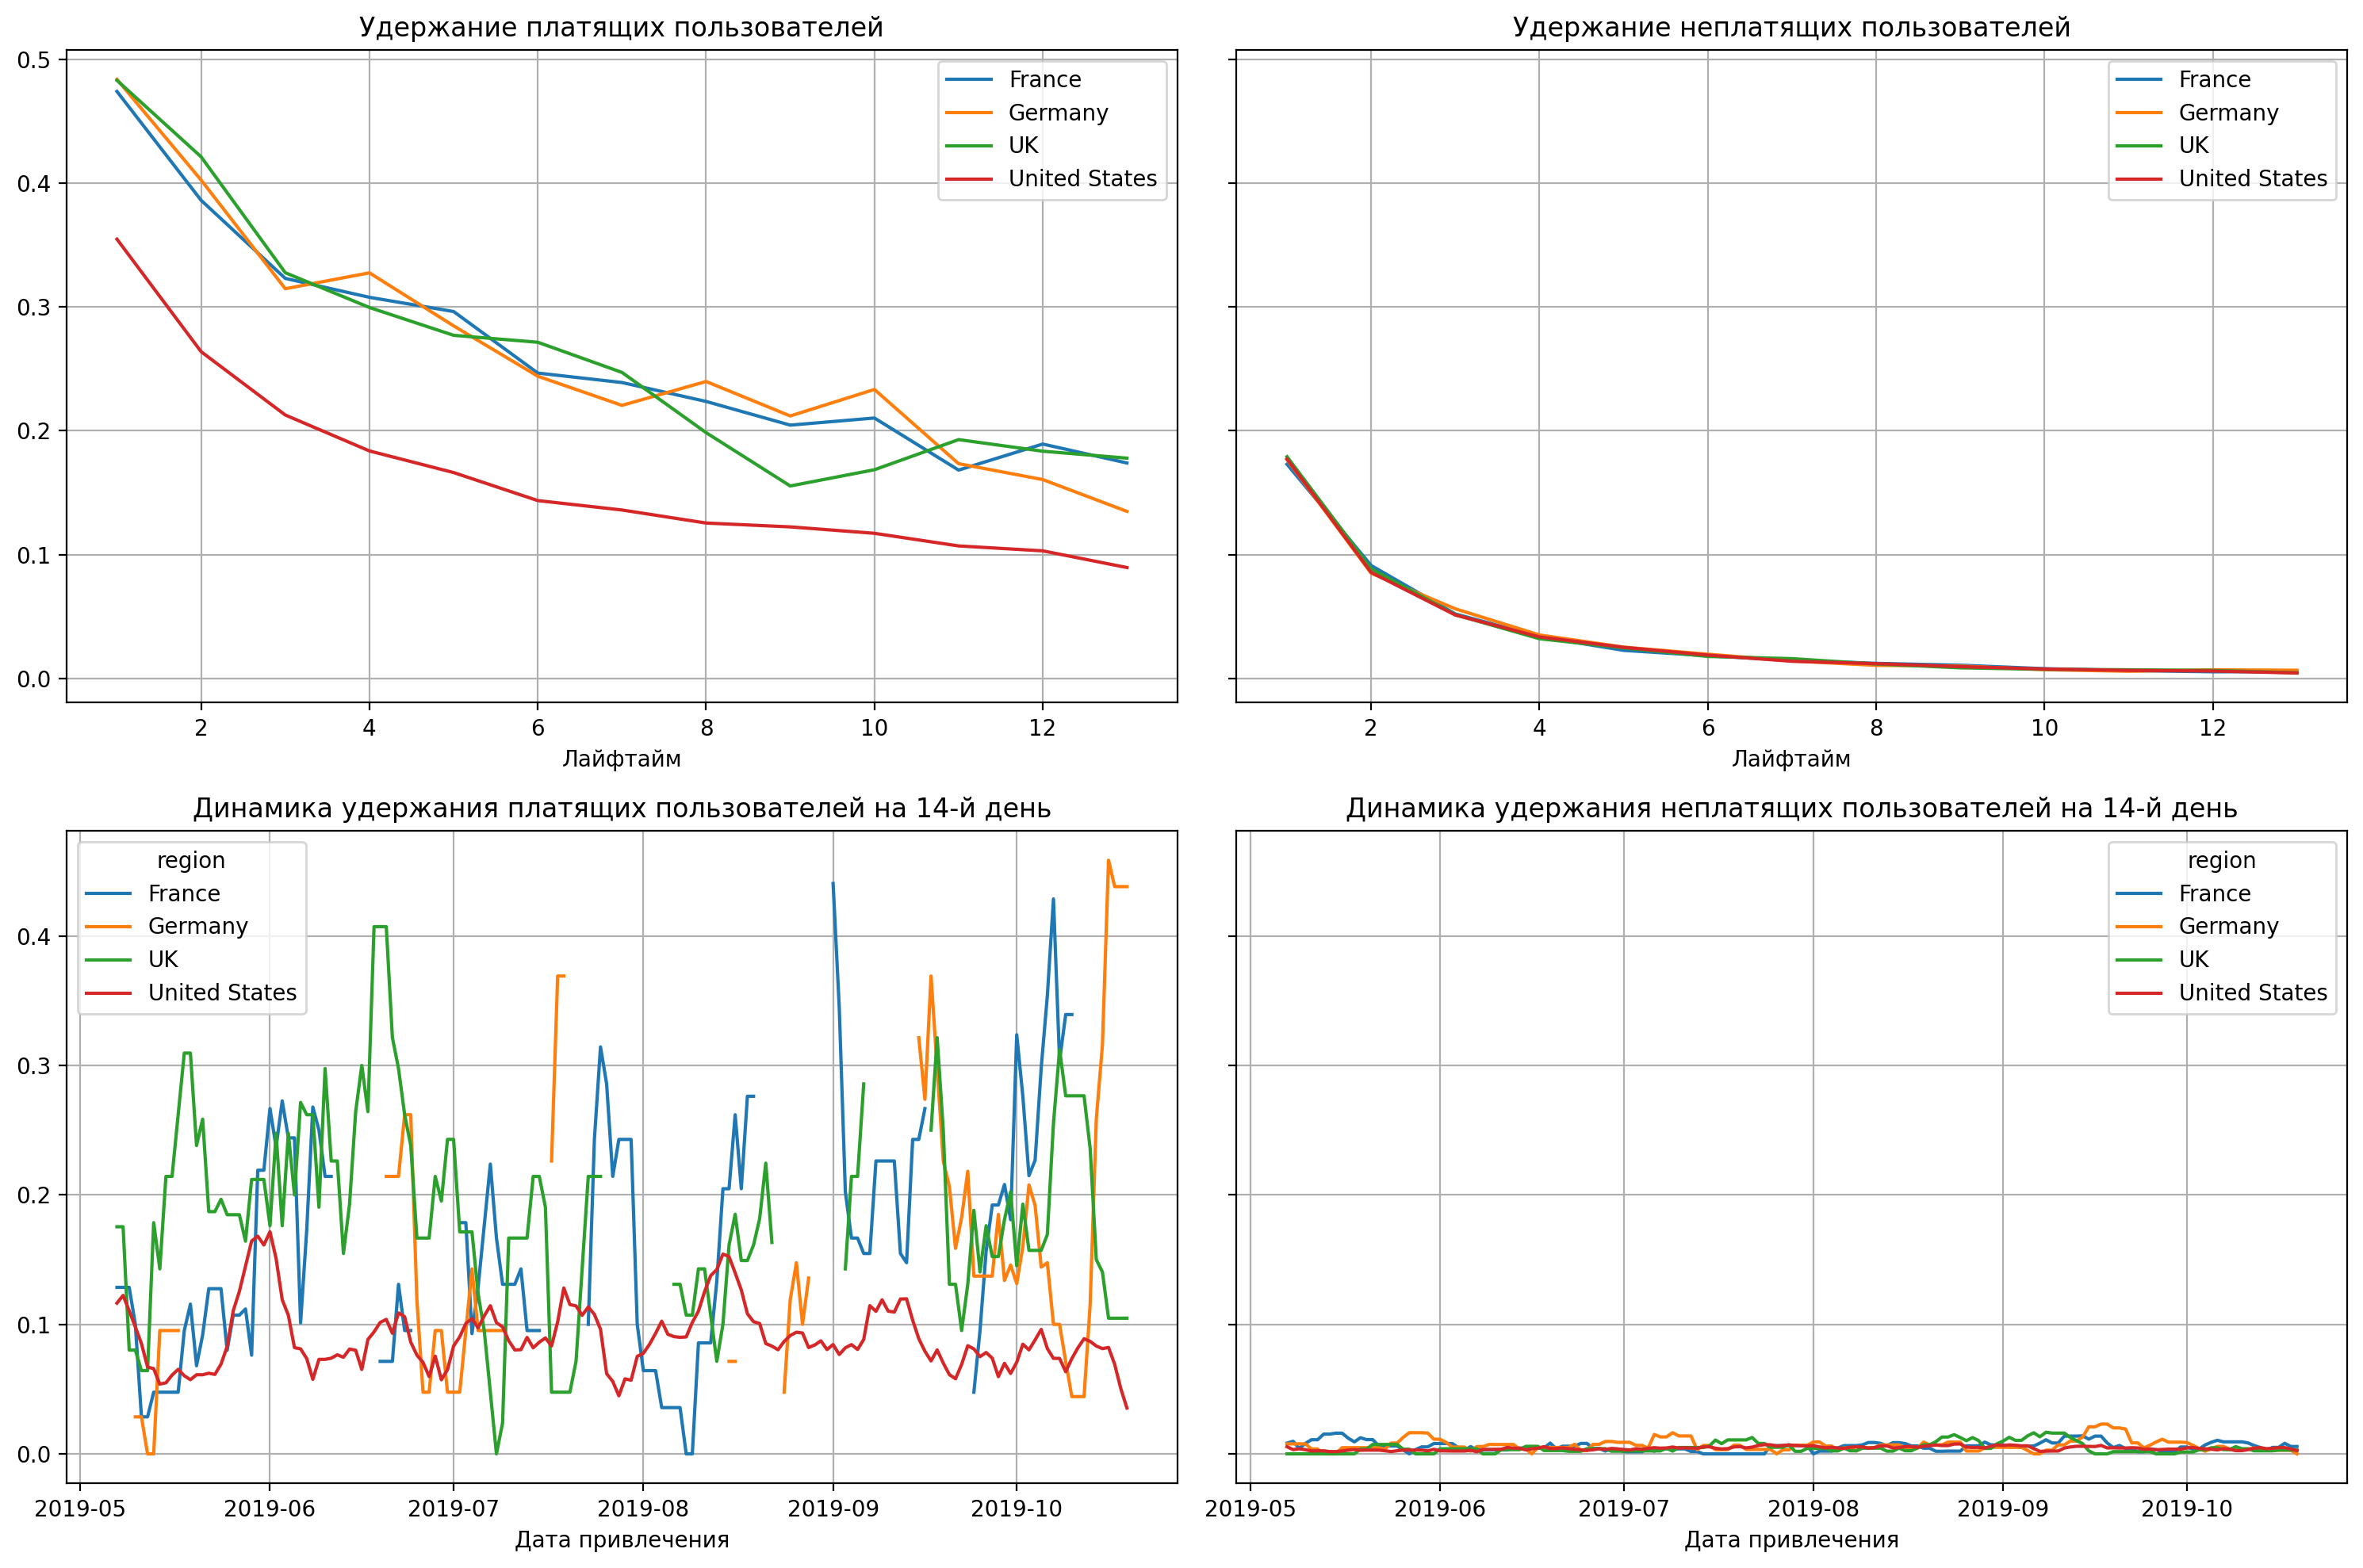

In [92]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Графики с разбивкой по странам красноречиво показывают, реклама не окупается только в Америке и что расходы на эту рекламу только растут. В этом регионе высокая конверсия и низкое удержание, высокий LTV. Похоже, реклама в Америке слишком дорогая.

### Окупаемость рекламы с разбивкой по рекламным каналам

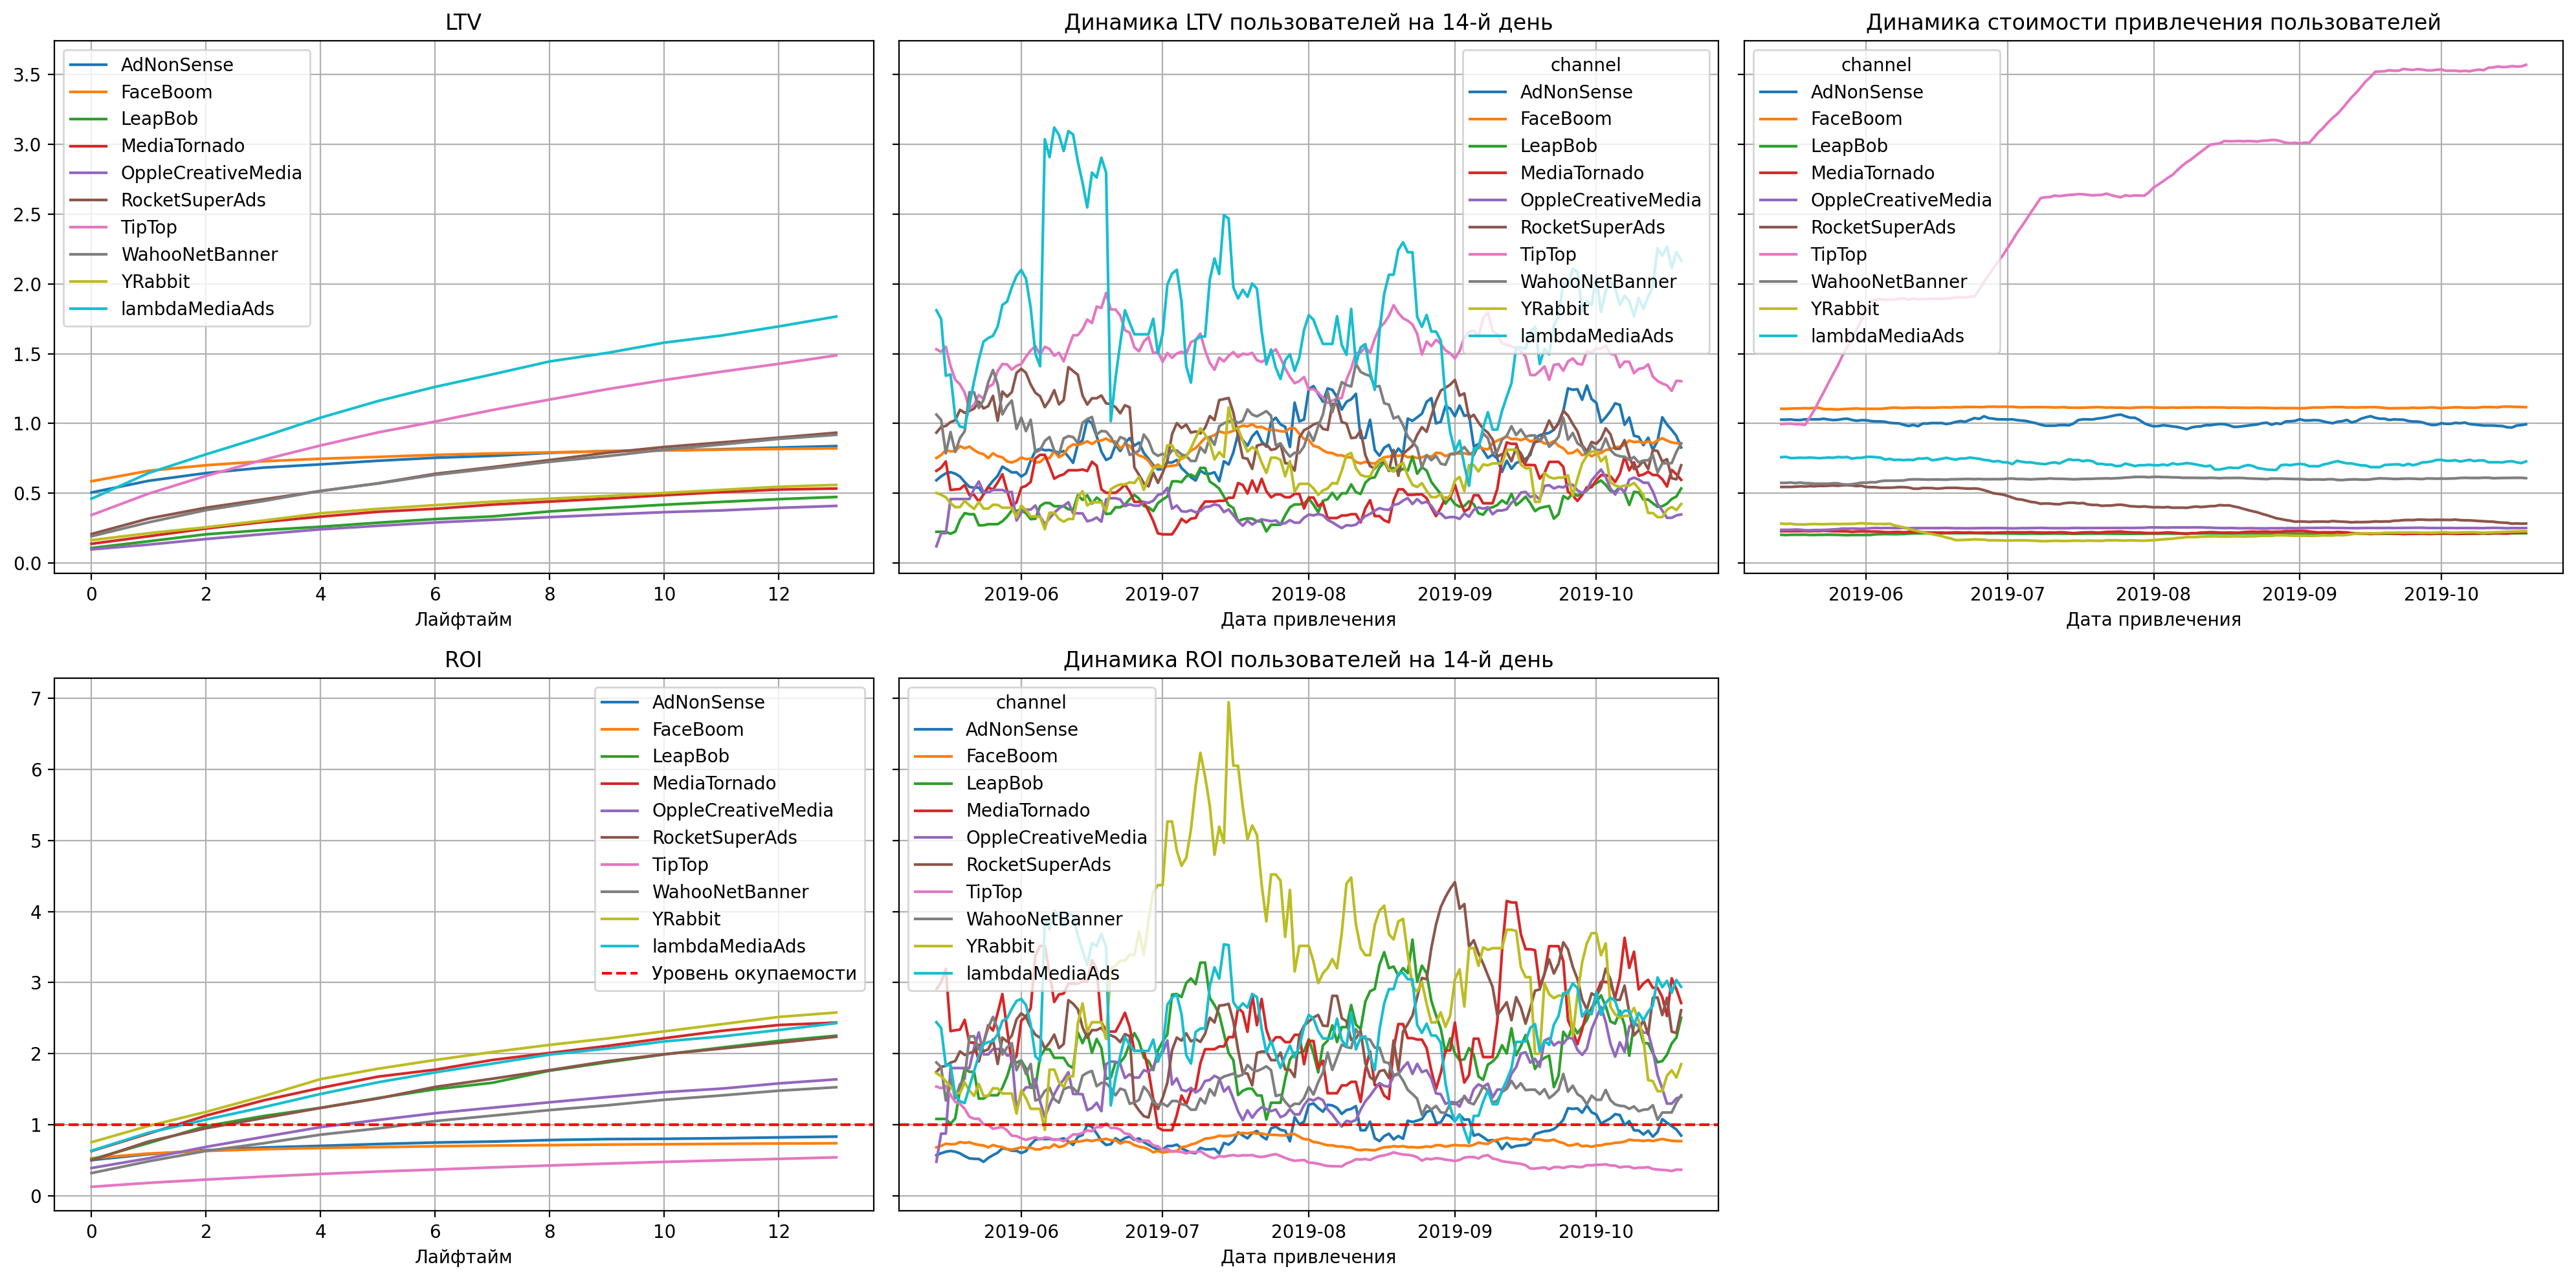

In [93]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

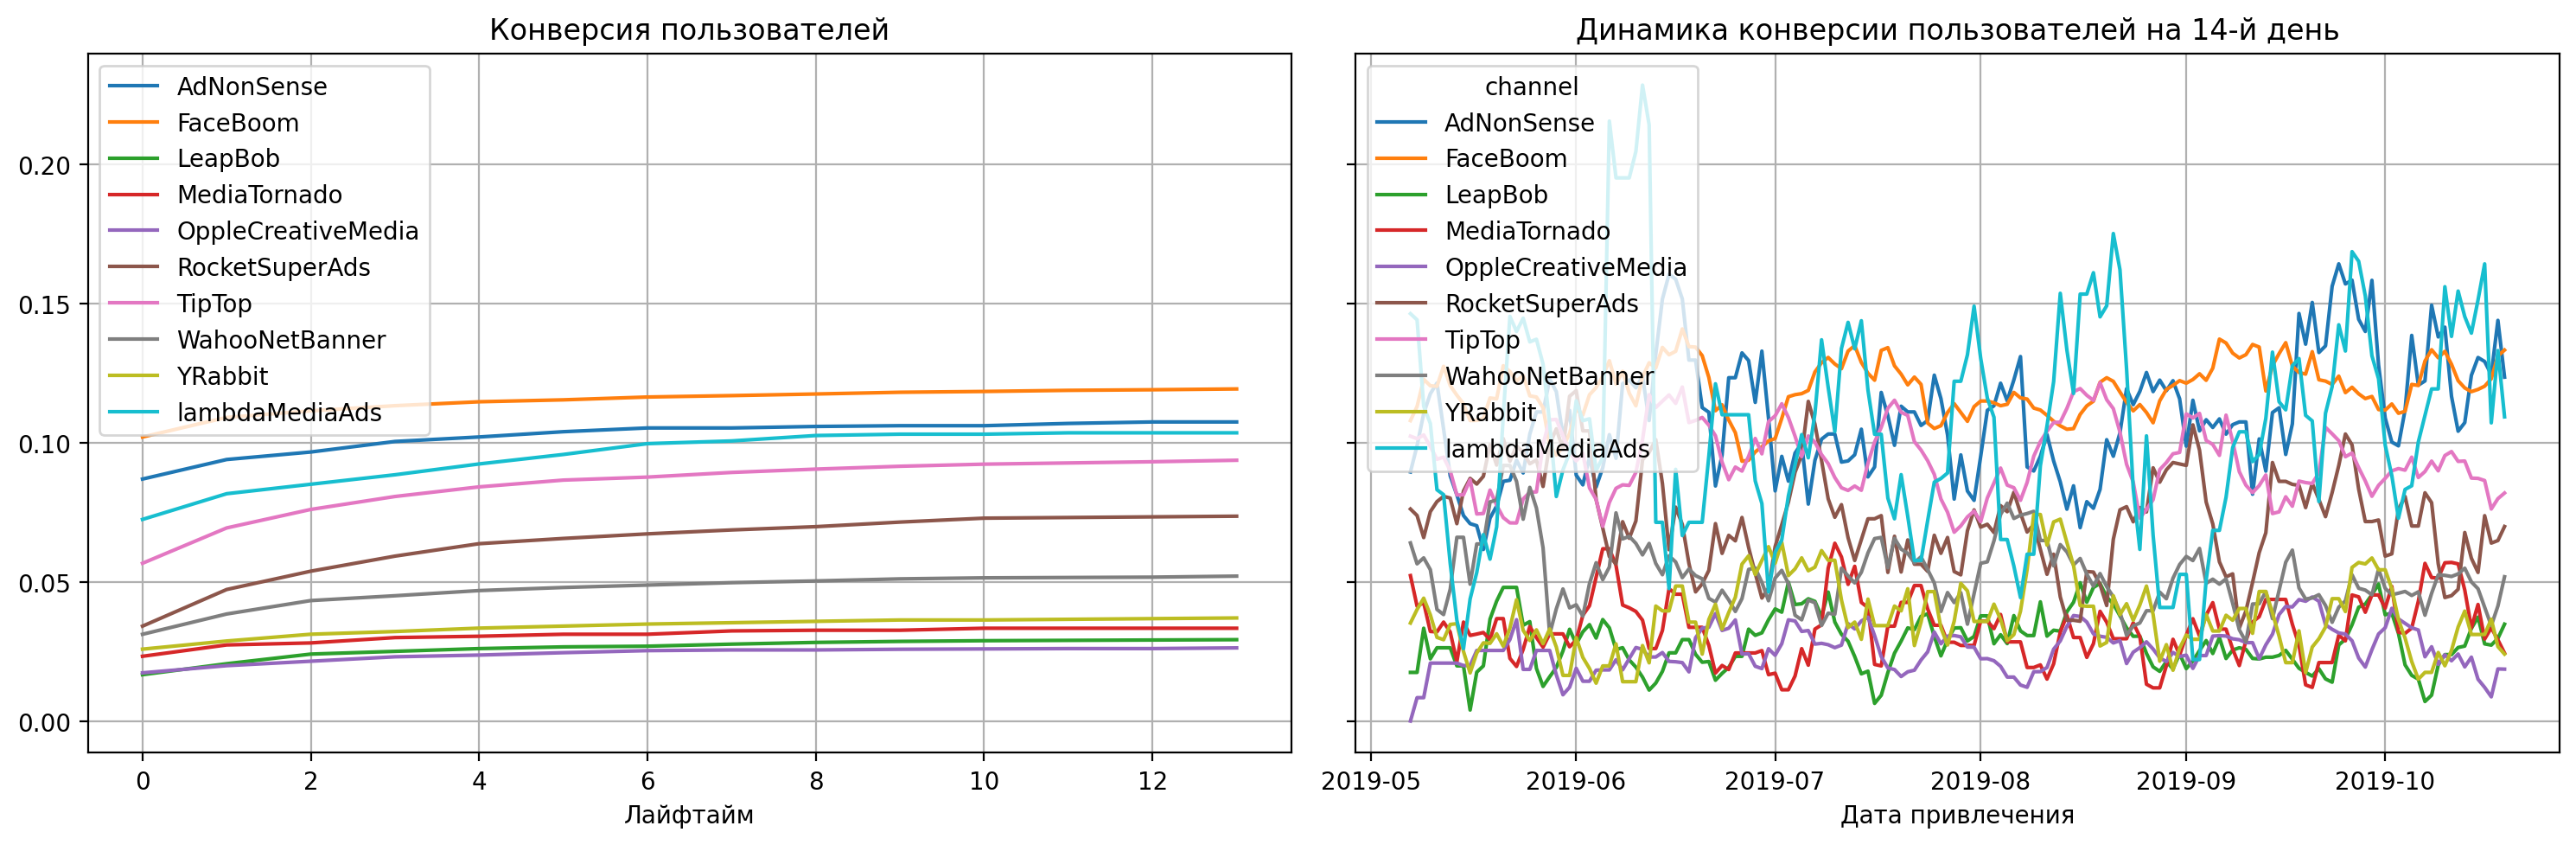

In [94]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

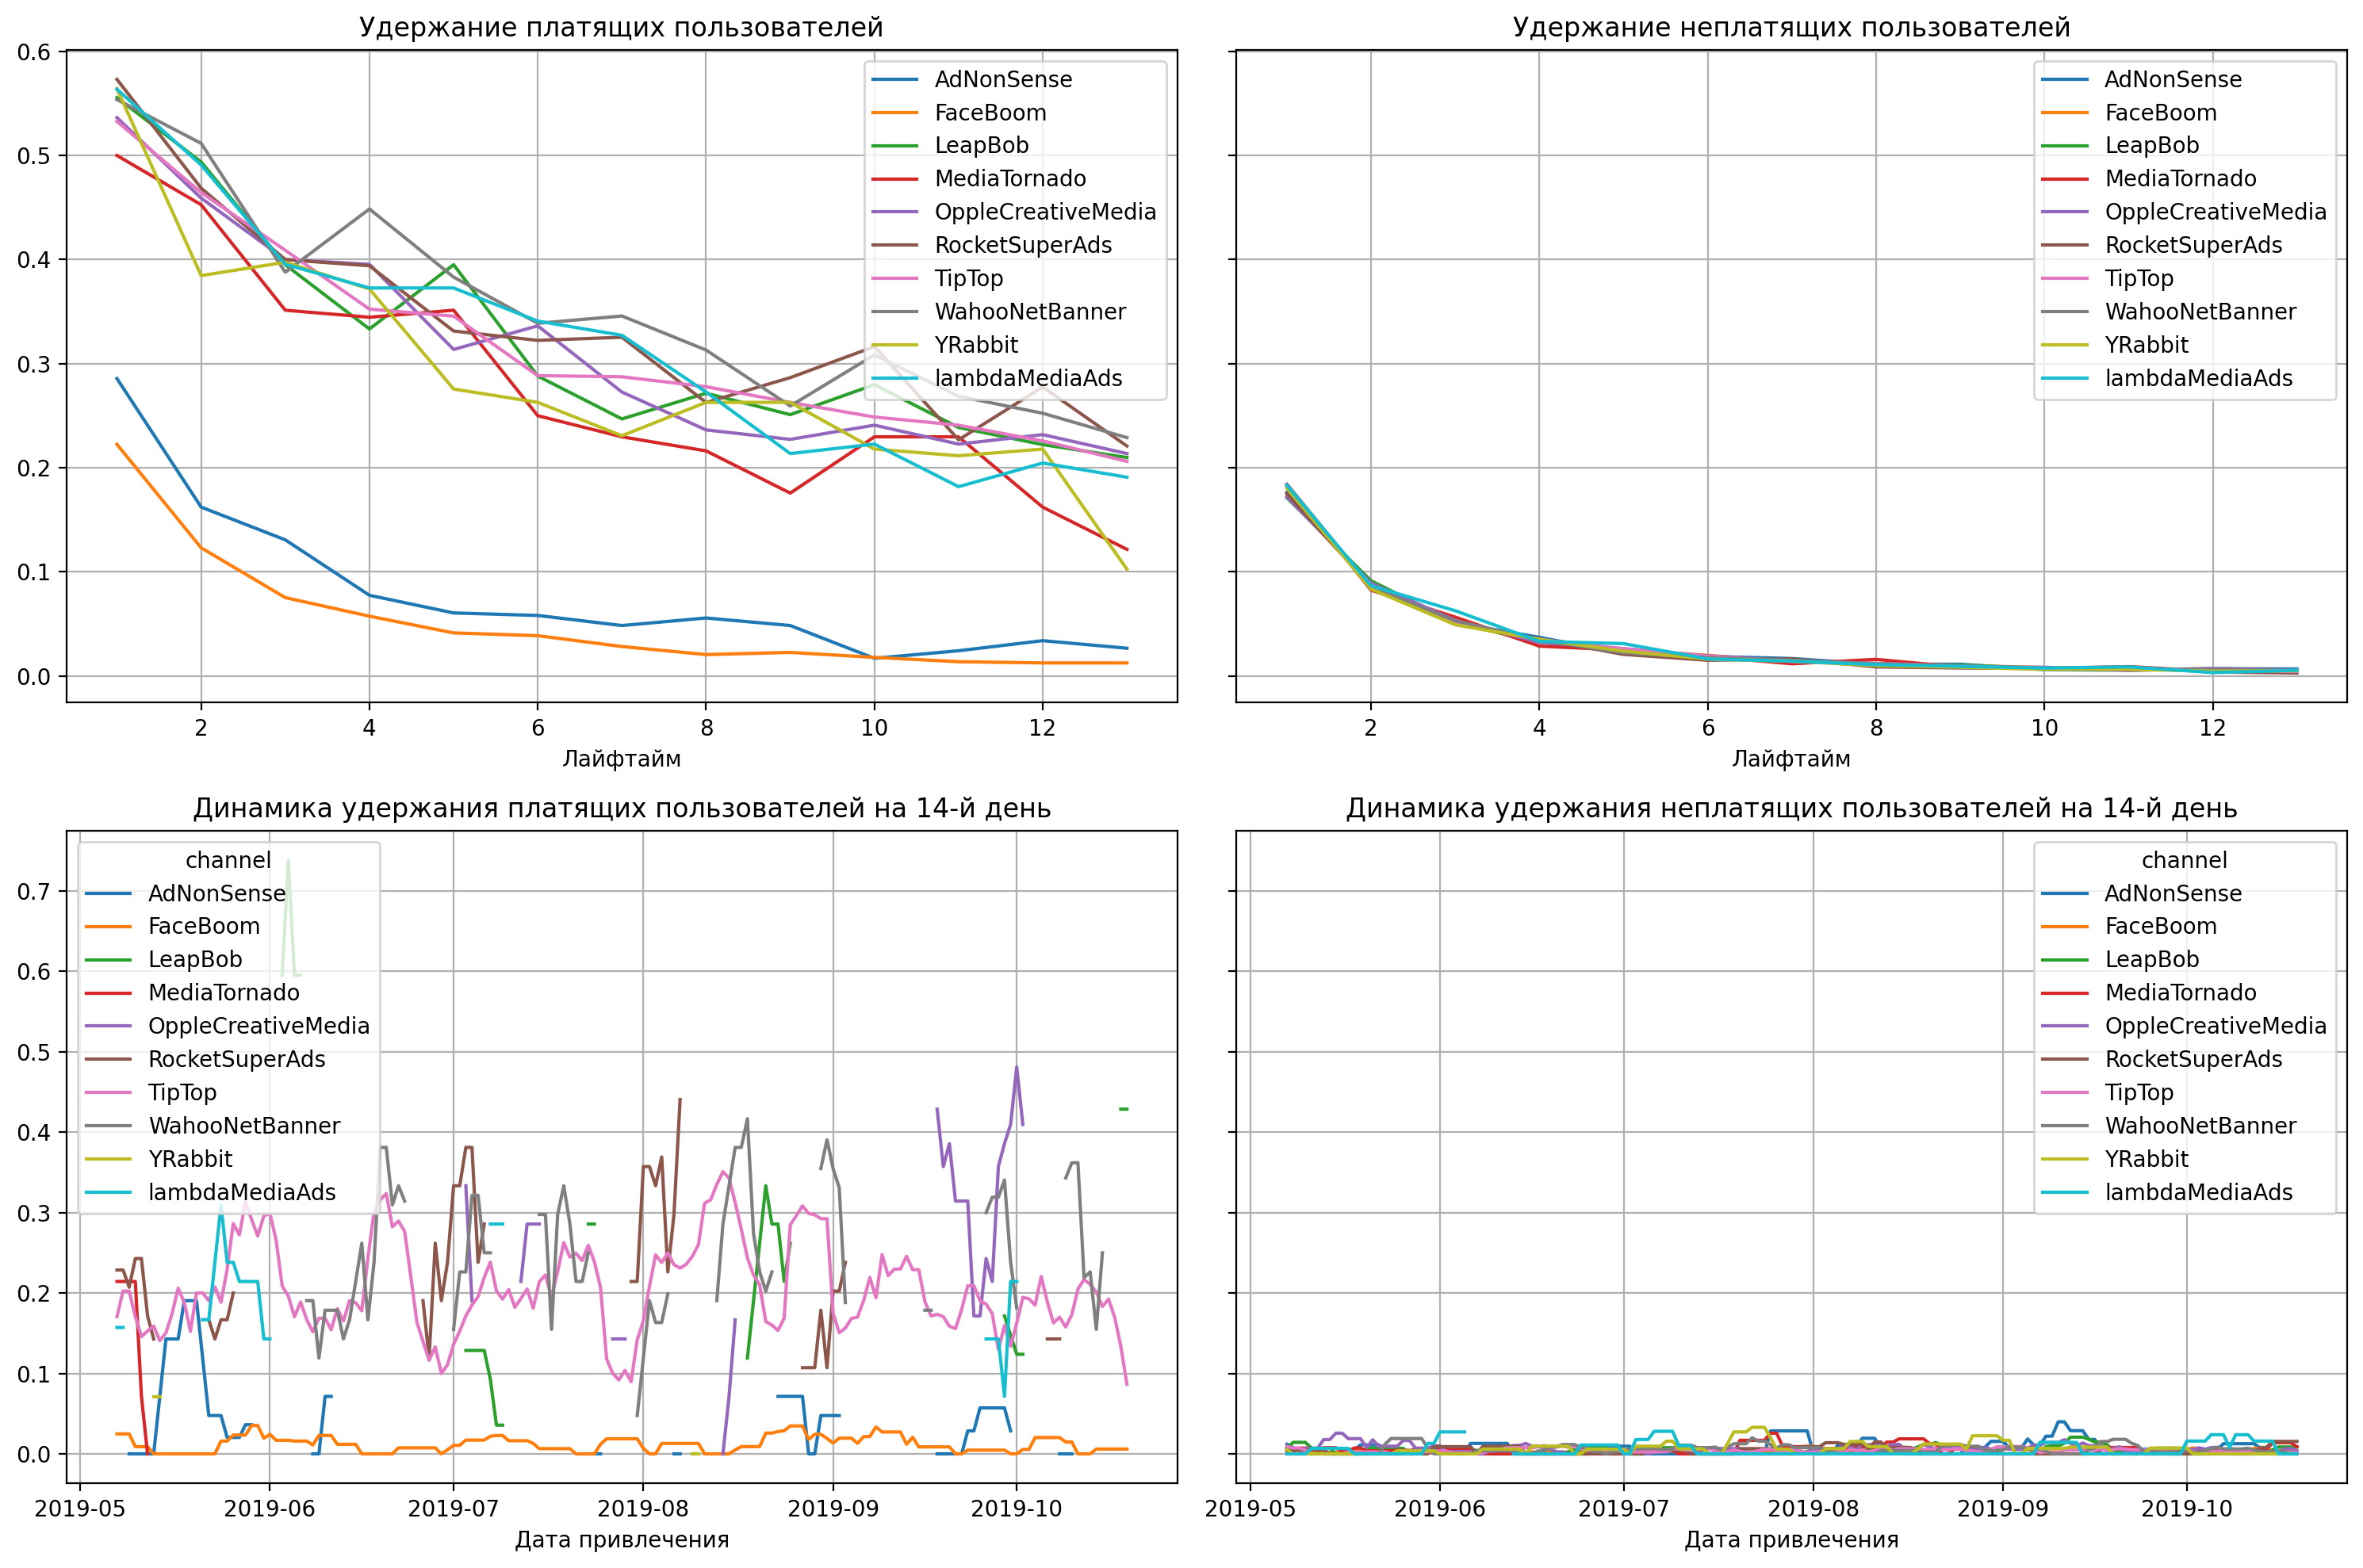

In [95]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

In [96]:
user_revenue.query('channel != "organic"').sort_values(by='acquisition_cost', ascending=False)

user_id  payer  acquisition_cost   revenue  cost_per_user  \
channel                                                                         
TipTop                19561   1878          54751.30  69574.76       2.799003   
FaceBoom              29144   3557          32445.60  25637.66       1.113286   
WahooNetBanner         8553    453           5151.00  20006.63       0.602245   
AdNonSense             3880    440           3911.25   3697.17       1.008054   
OppleCreativeMedia     8605    233           2151.25   8365.53       0.250000   
RocketSuperAds         4448    352           1833.00  11598.32       0.412095   
LeapBob                8553    262           1797.60   9560.13       0.210172   
lambdaMediaAds         2149    225           1557.60   8941.70       0.724802   
MediaTornado           4364    156            954.48   5752.32       0.218717   
YRabbit                4312    165            944.22   6201.43       0.218975   

                    cost_per_payer  revenue_per_payer  
channel                                                
TipTop                   29.154047          37.047263  
FaceBoom                  9.121619           7.207664  
WahooNetBanner           11.370861          44.164746  
AdNonSense                8.889205           8.402659  
OppleCreativeMedia        9.232833          35.903562  
RocketSuperAds            5.207386          32.949773  
LeapBob                   6.861069          36.489046  
lambdaMediaAds            6.922667          39.740889  
MediaTornado              6.118462          36.873846  
YRabbit                   5.722545          37.584424

In [97]:
profiles_with_orders.query('channel != "organic" & region != "United States"').groupby('channel').agg({'acquisition_cost':'sum', 'revenue':'sum'}).sort_values(by='acquisition_cost', ascending=False)

acquisition_cost   revenue
channel                                       
WahooNetBanner               5151.00  20006.63
AdNonSense                   3911.25   3697.17
OppleCreativeMedia           2151.25   8365.53
LeapBob                      1797.60   9560.13
lambdaMediaAds               1557.60   8941.70

In [98]:
profiles_with_orders.query('channel != "organic"').pivot_table(index=['region','device'], values=['acquisition_cost','revenue'], aggfunc='sum')

acquisition_cost   revenue
region        device                             
France        Android       1521.746204   4616.59
              Mac            530.732000   1973.24
              PC            2003.461346   7275.60
              iPhone        1020.034396   3198.79
Germany       Android       1283.672118   4237.82
              Mac            493.505057   1608.00
              PC            1773.966473   6015.47
              iPhone         873.079587   2631.99
UK            Android       1486.483207   6040.13
              Mac            484.690986   1561.20
              PC            2061.800062   7860.90
              iPhone        1035.528563   3551.43
United States Android      18168.727630  25580.45
              Mac          22585.609834  28265.17
              PC            9424.116830  12598.55
              iPhone       40750.145705  52320.32

TipTop, FaceBoom и AdNonSense - платформы с неокупаемой рекламой. Остальные источники траффика окупаются, и довольно быстро (2-6 дней). Траты на рекламу в TipTop растут несоразмерно остальным платформам. FaceBoom показывает самую высокую конверсию и самое низкое удержание (промокод на первую покупку?). 

## Выводы

Вложения в рекламу не окупаются, а расходы на рекламу увеличивались почти весь анализируемый период. Единственная окупаемая платформа - РС, причина этому - низкие траты на рекламу на этой платформе, что показывает в целом неэффективность решений о размещении рекламы. Платформы iPhone, Мас и Android при высокой конверсии, но и высокой стоимости привлечения показывают отсутствие окупаемости на протяжении почти всего лайфтайм пользователя.

Анализ в разрезе регионов показывает, что реклама не окупается только в Америке, куда выделено 86% рекламного бюджета. 96% этих денег ушло на платформы TipTop и FaceBoom, которые не окупаются. Америка в целом лидер по количеству пользователей, в том числе платящих (78%), однако при высокой конверсии это пользователи с очень низким удержанием. 
Траты на рекламу в TipTop растут несоразмерно остальным платформам, но количество привлеченных пользователей от месяца к месяцу почти не меняется. Потрачено на рекламу в TipTop 54.7 тыс., а выручка от пользователей TipTop составила 69,6 тыс.
Однозначно убыточна реклама в FaceBoom в Америке, на которую было потрачено 32.4 тыс., а выручка составила 25.6 тыс. 

В целом FaceBoom показывает самую высокую конверсию и самое низкое удержание, и привел 40% всех платящих пользователей. Возможно, привлеченным пользователям выдается промокод на первую покупку, а в дальнейшем они ничего не покупают.

Рекомендации для отдела маркетинга для повышения эффективности:

1) расходы на рекламу в FaceBoom следует либо сильно сократить, либо пересмотреть концепцию рекламного предложения, чтобы улучшить показатели удержания пользователя;
2) для американского рынка лучше размещать рекламу на платформах RocketSuperAds, МediaTornado и YRabbit, которые показывали хорошую окупаемость;
3) увеличение расходов на рекламу в TipTop не дает прироста количества пользователей. Видимо, реклама там постоянно дорожает, что объясняет неокупаемость при хорошем удержании и конверсии, так что расходы на эту платформу можно снизить;
4) AdNonSense - платформа с неокупаемой рекламой, которая приводит мало пользователей, от размещения здесь нужно отказатьтся;
5) рекламный бюджет стоит перенаправить на Великобританию, Францию и Германию, которые привлекают более платежеспособного пользователя. Платформы WahooNetBanner, OppleCreativeMedia, LeapBob, lambdaMediaAds показывают хорошик результаты в окупаемости рекламы в европейском направлении. PC - самая перспективная платформа для этих регионов.
